# <span style='color:SteelBlue'>P5 - Segmentez des clients d'un site e-commerce (part 2)</span>

<img src="https://asset.brandfetch.io/idvSn4Org5/idCJV4h5Ot.png" width="400" height="400">

# <span style='background:white; color:black'>Sommaire</span>

Importations des librairies utilisées dans ce notebook <br>

Paramètres d'affichage du notebook <br>

Fonctions utilisées dans ce notebook <br>

# <span style='background:red; color:white'>A METTRE A JOUR</span>

**Etape 1 : Description des données**


Conclusion

# <span style='background:blue'>Introduction</span>

Olist souhaite que nous fournissons à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Nous devons fournir à l’équipe Marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.
___

**Mission**

**Réaliser la segmentation des clients en utilisant des methodes non-superviséees**. Notre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles. Pour cela nous devons :
1. Réaliser une courte analyse exploratoire.
2. Tester différents modèles de segmentation afin de répondre au mieux à la problématique.
3. Créer une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

Ce notebook présente la 2ème partie. Nous allons donc réaliser **des essais de différentes approches de modélisation** de la segmentation des clients par un modèle de machine learning non-supervisé.
___

**Source des datasets**<br>
Olist nous fournit une base de données anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.

Ce dataset a été nettoyé et enrichi dans le notebook 1. Nous allons donc utiliser le dataset issu du notebook 1 pour réaliser la segmentation des clients.

nom du fichier : **olist_clients_segmentation.csv**

# <span style='background:grey'>Importations des librairies utilisées dans ce notebook</span>

In [1]:
# Librairies
import os.path
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import time
from IPython.display import display
import scipy
from datetime import datetime
import yellowbrick
import math
from scipy.stats import shapiro

# K-means
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler

# CAH
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram

# DBSCAN
from itertools import product
from sklearn.cluster import DBSCAN

# Affichage plot dans le notebook
%matplotlib inline

# Versions
print('Version des librairies utilisées :')
print('Python        : ' + sys.version)
print('Matplotlib    : ' + mpl.__version__)
print('NumPy         : ' + np.version.full_version)
print('Pandas        : ' + pd.__version__)
print('Scipy         : ' + scipy.__version__)
print('Seaborn       : ' + sns.__version__)
print('Yellowbrick   : ' + yellowbrick.__version__)

# Afficher heure lancement
maintenant = datetime.now().isoformat()
print('\nCode lancé le : ' + maintenant)

# Enregistrer l'heure de début
start_time = time.time()

Version des librairies utilisées :
Python        : 3.11.7 (tags/v3.11.7:fa7a6f2, Dec  4 2023, 19:24:49) [MSC v.1937 64 bit (AMD64)]
Matplotlib    : 3.8.2
NumPy         : 1.26.2
Pandas        : 2.1.4
Scipy         : 1.11.4
Seaborn       : 0.13.0
Yellowbrick   : 1.5

Code lancé le : 2023-12-19T00:16:47.779130


# <span style='background:grey'>Paramètres d'affichage du notebook</span>

In [2]:
# paramétrage des paramètres d'affichage dans le notebook (pour afficher les définitions des indicateurs)
pd.set_option('display.max_row', 100)
pd.set_option('display.max_column', 100)
pd.set_option('display.precision', 5)

# Création d'1 palette de couleurs
colors_list = ['Gold', 'MediumPurple', 'DarkOrange', 'LimeGreen', 'Tomato', 'SteelBlue', 'SaddleBrown', 'DeepPink', 'LightSkyBlue', 'OliveDrab']

# Définit le style de la police pour le titre des graphiques
font_title = {'family': 'Times New Roman',
                'color': '000000',  # Noir en notation hexadécimale
                'size': 22}

# Définit le style de la police pour les axes du graphique
font_axe = {'family': 'Times New Roman',
                'color': '000000',  # Noir en notation hexadécimale
                'size': 16}

# import warnings
# warnings.filterwarnings('ignore', category=FutureWarning)

# <span style='background:grey'>Fonctions utilisées dans ce notebook</span>

In [3]:
# #                            VISUALISER_CLUSTERS
# # ****************************************************************************

def visualiser_clusters(X, n_clusters=5, colors_list=colors_list, random_state=42):
    """
    Cette fonction crée et visualise un modèle KMeans avec un nombre spécifié de clusters.
    Elle affiche également un diagramme à secteurs montrant la répartition des observations par cluster.
    
    Paramètres :
    X : array-like, shape (n_samples, n_features)
        Les données à clusteriser.
    n_clusters : int, optional (default=5)
        Le nombre de clusters à former.
    colors_list : list of colors, optional
        La liste des couleurs à utiliser pour les clusters.
    random_state : int, optional (default=42)
        La graine pour le générateur de nombres aléatoires.
    """
    
    # Démarrer le compteur de temps
    start_fit_time_kmeans = time.time()
    
    # Création Kmeans (avec 10 initialisations différentes)
    model_kmeans = KMeans(n_clusters, n_init=10, random_state=random_state)
    
    # Création du visualiseur
    visualizer_selected = SilhouetteVisualizer(model_kmeans, colors=colors_list)
    
    # Fit le modèle sur les données
    visualizer_selected.fit(X)
    
    # Arrêter le compteur de temps
    temps_fit_kmeans = round(time.time() - start_fit_time_kmeans, 3)    
    
    # Afficher le graphique
    visualizer_selected.poof()
    plt.show()
    
    # Obtenir les labels de cluster pour chaque observation
    labels = visualizer_selected.labels_
    
    # Compter le nombre d'observations dans chaque cluster
    counts = np.bincount(labels)
    
    # Afficher le nombre d'observations dans chaque cluster
    for i, count in reversed(list(enumerate(counts))):
        print(f"Cluster {i}: {count} observations")
        
    # Créer un camembert pour visualiser la répartition des observations
    plt.figure(figsize=(12, 8))
    plt.title('Répartition des observations par cluster')
    plt.pie(counts, labels=[f'Cluster {i}' for i in range(len(counts))], colors=colors_list)
    
    # Créer et afficher la légende en dehors du graphique
    quartier_values = [f'{value:.1f}%' for value in counts / counts.sum() * 100]
    legend_labels = [f'Cluster {i}: {value}' for i, value in enumerate(quartier_values)]
    plt.legend(legend_labels, bbox_to_anchor=(1,1))
    plt.show()

In [4]:
# #                            TRACER_MOYENNE_PAR_CLUSTER
# # ****************************************************************************

def tracer_moyenne_par_cluster(df_cluster, colors_list=colors_list, font_axe=font_axe, font_title=font_title):
    """
    Cette fonction calcule la moyenne pour chaque caractéristique par cluster et trace un graphique à barres pour chaque caractéristique.
    
    Paramètres :
    df_cluster : DataFrame
        Le DataFrame contenant les données à analyser. Il doit contenir une colonne 'Cluster'.
    colors_list : list of colors
        La liste des couleurs à utiliser pour les barres du graphique.
    font_axe : dict
        Le dictionnaire définissant le style des étiquettes des axes.
    font_title : dict
        Le dictionnaire définissant le style du titre du graphique.
    
    Retourne :
    Moyenne par cluster : DataFrame
        Le DataFrame contenant la moyenne pour chaque feature par cluster.
    """
    
    # Claculer le nombre de col de rfm
    nb_feat = len(df_cluster.columns) - 1
    
    # Calculer la moyenne pour chaque feature par cluster
    moyenne_par_cluster = df_cluster.groupby('Cluster').mean()
    
    # Créer des sous-graphiques
    fig, axes = plt.subplots(nb_feat, 1, figsize=(15, 20))
    
    # Tracer la moyenne par cluster pour chaque caractéristique
    for i, caractéristique in enumerate(moyenne_par_cluster.columns):
        ax = axes[i]
        bars = ax.bar(moyenne_par_cluster.index, moyenne_par_cluster[caractéristique], color=colors_list)
        ax.set_xlabel('Cluster', fontdict=font_axe)
        ax.set_ylabel('Moyenne', fontdict=font_axe)
        ax.set_title(f'Moyenne par Cluster - {caractéristique}', fontdict=font_title)
        
        # Ajouter des étiquettes de données
        for bar in bars:
            hauteur = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, hauteur, round(hauteur, 1), va='bottom', fontsize=18)
    
    # Ajuster l'espacement entre les sous-graphiques
    plt.tight_layout()
    
    # Afficher le graphique
    plt.show()
    
    # Output
    return moyenne_par_cluster

In [5]:
# #                            TRACER RADAR PAR CLUSTER
# # ****************************************************************************

def tracer_radar_par_cluster(moyenne_par_cluster_scaled, alpha=0.25, colors_list=colors_list, font_axe=font_axe, font_title=font_title):
    """
    Cette procédure trace un graphique radar pour chaque cluster, montrant la moyenne de chaque caractéristique par cluster.

    Paramètres :
    moyenne_par_cluster_scaled : DataFrame
        Le DataFrame contenant les moyennes par cluster pour chaque feature. Les clusters sont les index et les caractéristiques sont les colonnes.
    alpha : float, optional (default=0.25)
        La transparence des graphiques radar.
    colors_list : list of colors
        La liste des couleurs à utiliser pour les graphiques radar.
    font_axe : dict
        Le dictionnaire définissant le style des étiquettes des axes.
    font_title : dict
        Le dictionnaire définissant le style du titre du graphique.
    
    Retourne :
    None
    """
    
    # Nombre de clusters et features
    num_clusters = moyenne_par_cluster_scaled.shape[0]
    num_vars = moyenne_par_cluster_scaled.shape[1]
    
    # Calculer l'angle de chaque axe (+ répéter le premier angle)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]
    
    # Créer une figure avec 3 subplots par ligne
    num_rows = math.ceil(num_clusters / 3)
    fig, axs = plt.subplots(num_rows, 3, figsize=(18, 6 * num_rows), subplot_kw=dict(polar=True))
    
    # Aplatir la liste d'axes
    axs = axs.flatten()
    
    # Pour chaque cluster
    for i, row in moyenne_par_cluster_scaled.iterrows():
        
        # Sélection du subplot du cluster
        ax = axs[i]        
        
        # création du graphique radar
        values = row.values.flatten().tolist()
        values += values[:1] 
        
        # Ajouter +0,01 à chaque valeur pour éviter une valeur nulle
        values = [value + 0.01 for value in values]
        
        # Tracer le graphique radar
        ax.fill(angles, values, color=colors_list[i], alpha=alpha)
        
        # Etiquettes de l'axe x avec les features
        labels = list(moyenne_par_cluster_scaled.columns)
        labels += labels[:1]
        ax.set_xticks(angles)
        ax.set_xticklabels(labels, fontdict=font_axe)
        
        # Fixer les limites de l'axe y
        ax.set_ylim(0, 1)
        
        # Titre du subplot
        ax.set_title(f'Cluster {i}', fontdict=font_title)
    
    # Supprimer les subplots inutilisés
    for i in range(num_clusters, num_rows * 3):
        fig.delaxes(axs[i])
    
    # Ajuster l'espacement entre les subplots
    plt.tight_layout()
    plt.show()

In [6]:
# # #                            CALCUL_COEF_GINI
# # # ****************************************************************************

# def calcul_coef_gini(df_clustered, client_col_nom='customer_unique_id', cluster_col_nom='Cluster'):
#     """
#     Cette fonction calcule le coefficient de Gini pour chaque cluster dans un DataFrame.

#     Paramètres :
#     df_clustered : DataFrame
#         Le DataFrame contenant les données clusterisées. Il doit contenir une colonne pour les identifiants des clients et une colonne pour les identifiants des clusters.
#     client_col_nom : str, optional (default='customer_unique_id')
#         Le nom de la colonne contenant les identifiants des clients.
#     cluster_col_nom : str, optional (default='Cluster')
#         Le nom de la colonne contenant les identifiants des clusters.
    
#     Retourne :
#     coef_gini : Series
#         Une série contenant le coefficient de Gini pour chaque cluster.
#     """
    
#     # Calculer le nombre de clients par cluster
#     counts = df_clustered.groupby([cluster_col_nom, client_col_nom]).size()
    
#     # Calculer le nombre total de clients par cluster
#     total_counts = df_clustered.groupby(cluster_col_nom).size()
    
#     # Calculer la somme des carrés des proportions des clients par cluster
#     p_squared = (counts/total_counts).groupby(level=0).apply(lambda x: (x**2).sum())
    
#     # Calculate the Gini coefficients
#     coef_gini = 1 - p_squared
    
#     # Output
#     return coef_gini

In [7]:
# # #                            CALCUL_COEF_GINI
# # # ****************************************************************************

def gini(clusters_labels):
    """Compute the Gini coefficient for a clustering.
    Parameters:
        - clusters_labels: pd.Series of labels of clusters for each point.
    """
    
    # Transformation en df
    clusters_labels = pd.Series(clusters_labels)
    
    # Compte le nombre d'occurences de chaque cluster
    frequencies = clusters_labels.value_counts()
    
    # Valeur absolue des écart à la moyenne 
    mad_value = abs(frequencies - frequencies.mean()).mean()
    # mad_value = frequencies.mad() # déprécié depuis Pandas 1.5.0
    
    # Moyenne des fréquences
    mean = frequencies.mean()
    
    # Gini coefficient
    gini_coeff = 0.5 * mad_value / mean
    
    # Output
    return gini_coeff

In [8]:
# #                            AFFICHER_BOXPLOT
# # ****************************************************************************

def afficher_boxplot(df, cluster_col_nom='Cluster', outliers=False):
    """
    Cette procédure affiche un boxplot pour chaque cluster dans un DataFrame.
    
    Paramètres :
    df : DataFrame
        Le DataFrame contenant les données à afficher. Il doit contenir une colonne pour les identifiants des clusters.
    cluster_col_nom : str, optional (default='Cluster')
        Le nom de la colonne contenant les identifiants des clusters.
    outliers : bool, optional (default=False)
        Si True, affiche les outliers sur le boxplot.
    
    Retourne :
    None
    """
    
    # Pour chaque colonne (feature) dans le DataFrame
    for col in df.columns:
        if col != cluster_col_nom:
            
            # Créer une nouvelle figure
            plt.figure()
            
            # Pour chaque valeur unique de l'axe x, triées dans l'ordre croissant
            for cluster in sorted(df[cluster_col_nom].unique()):
                
                # Sélectionner les données pour ce cluster
                data = df[df[cluster_col_nom] == cluster]
                
                # Définir la couleur du boxplot
                color = colors_list[cluster]
                
                # Afficher un boxplot sans les outliers
                sns.boxplot(x=cluster_col_nom, y=col, data=data, color=color, showfliers=outliers)
            
            # Ajouter la moyenne sur le boxplot
            sns.pointplot(x=cluster_col_nom, y=col, data=df, color='red', marker='*', estimator=np.mean, errorbar=None, linestyle='none')
            
            # Ajouter un titre à la figure
            if outliers:
                plt.title(f'Boxplot de {col} par {cluster_col_nom} avec outliers')
            else:
                plt.title(f'Boxplot de {col} par {cluster_col_nom} sans outliers')
            
            # Afficher la figure
            plt.show()

In [9]:
# #                            PLOT DISTRIBUTION
# # ****************************************************************************

def plot_distribution(df, col, color, binwidth=None, shapiro_wilk=False, unit=None):
    """
    Procédure qui affiche la distribution de la colonne sous forme d'histogramme et une boîte à moustaches.
    
    :param df: data frame à analyser (df)
    :param col: nom de la colonne (str)
    :param color: couleur pour l'histogramme (str)
    :param binwidth: largeur des barres de l'histogramme (int or float) (optionnel)
    :param shapiro_wilk: Effectuer le test de Shapiro-Wilk (booléen) (optionnel)
    :param unit: Unités pour l'axe X (str) (optionnel)
    """
    
    # Création de sous-plots pour l'histogramme et la boîte à moustaches
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # SI le test de Shapiro-Wilk est effectué
    if shapiro_wilk:

        # Effectuez test de S-W et écrire le résultat dans le titre du graphique
        sw_statistic, p_value = shapiro(df[col])
        sw_texte = "Distribution '{0}' Test S-W :{1:.2f} / p-value = {2:.2f}".format(col, sw_statistic, p_value)
        axes[0].set_title(sw_texte, fontdict=font_title, fontsize=14)
    else:
        # SI pas de test de Shapiro-Wilk, affichage titre par défaut
        axes[0].set_title("Distribution '{0}'".format(col), fontdict=font_title)
    
    # Graphique de l'histogramme
    if binwidth is not None:
        sns.histplot(df[col], kde=True, color=color, binwidth=binwidth, ax=axes[0])
    else:
        sns.histplot(df[col], kde=True, color=color, ax=axes[0])
    
    # Étiquetage de l'axe X avec les unités (si spécifiées)
    if unit:
        axes[0].set_xlabel("{0}".format(unit), fontdict=font_axe)
    else:
        axes[0].set_xlabel("Valeur", fontdict=font_axe)
    
    # Graphique de la boîte à moustaches
    sns.boxplot(x=df[col], color=color, ax=axes[1])
    axes[1].set_title("Boxplot '{0}'".format(col), fontdict=font_title)
    
    # Étiquetage de l'axe X avec les unités (si spécifiées)
    if unit:
        axes[1].set_xlabel("{0}".format(unit), fontdict=font_axe)
    else:
        axes[1].set_xlabel("Valeur", fontdict=font_axe)
    
    # Ajustement de l'espacement entre les sous-plots
    plt.tight_layout()
    
    # Affichage des graphiques
    plt.show()

In [10]:
# #                            STATS DESCRIPTIVES
# # ****************************************************************************

def stats_descriptives(df, col):
    """
    Fonction qui calcule tous les statitiques descriptives du dataframe.
    
    :param df: data frame à analyser (df)
    :param col: nom de la colonne (str)
    
    :return df_stat: data frame des stats descriptives (df)
    """
    
    # Liste des stats (ajouter 'classe modale' si besoin)
    stat_list = ['Q1', 'moyenne', 'médiane', 'Q3', 'ecart-type', 'CV', 'skewness', 'kurtosis']  
    
    # Stats descriptives (arrondis après la virgule)
    # Calcul des quartiles (Q1 et Q3)
    q1 = df[col].quantile(0.25).round(1)
    mean = df[col].mean().__round__(1)
    median = df[col].median().__round__(1)
    q3 = df[col].quantile(0.75).round(1)
    # mode, nb_element = classe_modale(df[col], arrondi_nb=1)
    std = df[col].std(ddof=0).__round__(1)
    cv = round(std / mean, 2)
    skew = df[col].skew().__round__(2)
    kurtosis = df[col].kurtosis().__round__(1)
    
    # On écrit la phrase de la classe modale
    # classe_mod = "{0}: {1} élément(s)".format(mode, nb_element)
    
    # Rassembler dans une liste (ajouter 'classe modale' si besoin)
    list_stat = [q1, mean, median, q3, std, cv, skew, kurtosis]
    
    # Transformation en data frame (en transposant horizontalement)
    df_stat = pd.DataFrame(list_stat, index=stat_list).T
    
    # Outputs
    return df_stat

In [11]:
# #                            CLUSTERING_ESTIMATOR
# # ****************************************************************************

class ClusteringEstimator:
    """
    Classe pour estimer les performances d'un algorithme de clustering.
    
    Attributs
    ----------
    estimator : objet
        L'algorithme de clustering à évaluer.
    performance_metrics : DataFrame
        DataFrame pour stocker les métriques de performance.
    hyperparameters : dict
        Dictionnaire pour stocker les hyperparamètres de l'algorithme.
    """
    
    # Constructeur (création df vide)
    def __init__(self, estimator):
        """
        Constructeur de la classe.
        
        Paramètres
        ----------
        estimator : objet
            L'algorithme de clustering à évaluer.
        """
        self.estimator = estimator
        self.performance_metrics = pd.DataFrame(columns=['Hyperparametre', 'distance_metric' , 'Coefficient silhouette', 'Indice Gini', 'Temps calcul', 'Nombre Clusters'])
    
    # Methode pour définir les hyperparamètres
    def set_hyperparameters(self, params):
        """
        Methode pour définir les hyperparamètres de l'algorithme.
        
        Paramètres
        ----------
        params : dict
            Les hyperparamètres à définir.
        """
        self.estimator.set_params(**params)
        self.hyperparameters = params
    
    def calculate_silhouette_score(self, X, distance_metric='euclidean'):
        """
        Methode pour calculer le score de silhouette de l'algorithme.
        
        Paramètres
        ----------
        X : array-like
            Les données à utiliser pour le calcul du score.
        distance_metric : str, optional
            La métrique de distance à utiliser pour le calcul du score de silhouette. Par défaut, 'euclidean'.
        """

        # Calcul du nombre de clusters
        labels = self.estimator.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        
        # SI >1 clusters ALORS calcul score de silhouette selon distance_metric
        if n_clusters > 1:
            silhouette_coeff = silhouette_score(X, labels, metric=distance_metric)
        
        # Pas de silhouette si un seul cluster
        else:
            silhouette_coeff = None 
        
        return silhouette_coeff
    
    # Methode pour calculer les métriques de performance
    def fit(self, X, distance_metric='euclidean'):
        """
        Methode pour calculer les métriques de performance de l'algorithme.
        
        Paramètres
        ----------
        X : array-like
            Les données à utiliser pour l'ajustement de l'algorithme.
        """
        
        # Calcul temps de calcul pour le fit
        start_time = time.time()
        self.estimator.fit(X)
        end_time = time.time()
        
        # Nombre de clusters
        labels = self.estimator.labels_
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        
        # Calcul du score de silhouette
        silhouette_coeff = self.calculate_silhouette_score(X, distance_metric)
        
        # Calcul index de Gini
        gini_index = gini(labels)
        
        # Création d'1 ligne de résultats synthétique
        new_row = pd.DataFrame({
            'Hyperparametre': [self.hyperparameters],
            'distance_metric': [distance_metric],
            'Coefficient silhouette': [silhouette_coeff],
            'Indice Gini': [gini_index],
            'Temps calcul': [end_time - start_time],
            'Nombre Clusters': [n_clusters]
        })
        
        # Concaténation des résultats
        if self.performance_metrics.empty:
            self.performance_metrics = new_row
        else:
            self.performance_metrics = pd.concat([self.performance_metrics, new_row], ignore_index=True)
    
    def plot(self, plot_type='silhouette', distance_metrics=None):
        """
        Methode pour afficher un graphique des 3 résultats (coefficient de silhouette / Indice de Gini / Temps de calcul) en fonction du nombre de clusters.
        
        Paramètres
        ----------
        plot_type : str, optional
            Le type de graphique à afficher. Les options sont 'silhouette', 'silhouette', 'gini', 'temps'. Par défaut, 'silhouette' sont affichés.
        distance_metrics : list of str, optional
            Les métriques de distance à utiliser pour filtrer les résultats. Si None, tous les résultats sont affichés.
        """
        
        # Nom de l'estimateur
        estimator_name = type(self.estimator).__name__
        
        # Si aucune métrique de distance n'est spécifiée, utiliser toutes les métriques de distance uniques dans les performance_metrics
        if distance_metrics is None:
            distance_metrics = self.performance_metrics['distance_metric'].unique()
        
        # Pour chaque métrique de distance spécifiée
        for plot_type in plot_type.split(','):
            plt.figure(figsize=(12, 8))
            
            # POUR chaque métrique de distance
            for i, distance_metric in enumerate(distance_metrics):

                # Filtrer les performance_metrics pour la distance_metric
                performance_metrics = self.performance_metrics[self.performance_metrics['distance_metric'] == distance_metric]
                
                # Tracer les résultats pour la métrique de distance actuelle
                if plot_type in ['silhouette']:
                    plt.plot(performance_metrics['Nombre Clusters'], performance_metrics['Coefficient silhouette'], marker='o', color=colors_list[i], label=distance_metric)
                
                elif plot_type in ['gini']:
                    plt.plot(performance_metrics['Nombre Clusters'], performance_metrics['Indice Gini'], marker='o', color=colors_list[i], label=distance_metric)
                
                elif plot_type in ['temps']:
                    plt.plot(performance_metrics['Nombre Clusters'], performance_metrics['Temps calcul'], marker='o', color=colors_list[i], label=distance_metric)
            
            # Ajouter une légende avec un titre
            plt.legend(loc='best', title='Métriques de distance')
            
            # Ajouter des titres et des labels
            plt.title(f'{plot_type.capitalize()} pour chaque cluster ({estimator_name})', fontdict=font_title)
            plt.xlabel('Nombre de clusters', fontdict=font_axe)
            plt.ylabel(plot_type.capitalize(), fontdict=font_axe)
            plt.show()

    def plot_dbscan(self, plot_type='silhouette', min_samples_range=None):
        """
        Methode pour afficher un graphique des 3 résultats (coefficient de silhouette / Indice de Gini / Temps de calcul) en fonction du nombre de clusters pour un DB SCAN.
        
        Paramètres
        ----------
        plot_type : str, optional
            Le type de graphique à afficher. Les options sont 'silhouette', 'silhouette', 'gini', 'temps'. Par défaut, 'silhouette' sont affichés.
        distance_metrics : list of str, optional
            Les métriques de distance à utiliser pour filtrer les résultats. Si None, tous les résultats sont affichés.
        """
        
        # Nom de l'estimateur
        estimator_name = type(self.estimator).__name__
        
        # Si aucune métrique de distance n'est spécifiée, utiliser toutes les métriques de distance uniques dans les performance_metrics
        if min_samples_range is None:
            min_samples_range = self.performance_metrics['min_samples'].unique()
        
        # Pour chaque métrique de distance spécifiée
        for plot_type in plot_type.split(','):
            plt.figure(figsize=(12, 8))
            
            # POUR chaque métrique de distance
            for i, min_samples in enumerate(min_samples_range):

                # Convert the 'Hyperparametre' column to string type
                self.performance_metrics['Hyperparametre'] = self.performance_metrics['Hyperparametre'].astype(str)

                # Filtrer les performance_metrics pour min_samples
                performance_metrics = self.performance_metrics[self.performance_metrics['Hyperparametre'].str.split(',').str[1].str.contains("'min_samples': {0}".format(min_samples))]
                
                # Tracer les résultats pour la métrique de distance actuelle
                if plot_type in ['silhouette']:
                    plt.plot(performance_metrics['Nombre Clusters'], performance_metrics['Coefficient silhouette'], marker='o', color=colors_list[i], label=min_samples)
                
                elif plot_type in ['gini']:
                    plt.plot(performance_metrics['Nombre Clusters'], performance_metrics['Indice Gini'], marker='o', color=colors_list[i], label=min_samples)
                
                elif plot_type in ['temps']:
                    plt.plot(performance_metrics['Nombre Clusters'], performance_metrics['Temps calcul'], marker='o', color=colors_list[i], label=min_samples)
            
            # Ajouter une légende avec un titre
            plt.legend(loc='best', title='min_samples')
            
            # Ajouter des titres et des labels
            plt.title(f'{plot_type.capitalize()} pour chaque cluster ({estimator_name})', fontdict=font_title)
            plt.xlabel('Nombre de clusters', fontdict=font_axe)
            plt.ylabel(plot_type.capitalize(), fontdict=font_axe)
            plt.show()

# <span style='background:grey'>Importation des données</span>

Importation du fichiers CSV avec Pandas

In [12]:
# Définir le chemin
chemin = "./data/cleaned/"

# Obtenir une liste de tous les fichiers dans le répertoire
fichiers = os.listdir(chemin)

# Initialiser un dictionnaire vide et le print de la liste des fichiers importés
data_brut = {}
print('===> Liste des fichiers importés: <====\n')

# Boucle sur chaque fichier
for fichier in fichiers:
    
    # Traiter uniquement les fichiers .csv
    if fichier.endswith('.csv'):
        print(fichier)
        
        # Lire le fichier csv et le stocker dans le dictionnaire
        data_brut[fichier] = pd.read_csv(chemin + fichier, sep="\t", encoding='utf-8', index_col='customer_unique_id')

===> Liste des fichiers importés: <====

olist_clients_segmentation.csv


Nous isolons le contenu du fichier dans un dataframe. 

In [13]:
# Fichier un df
df_data = data_brut['olist_clients_segmentation.csv']

# Afficher aperçu et dimension du df
display(df_data.head(3))
display(df_data.shape)

,recence,frequence,montant,satisfaction
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19,4.0
0000f46a3911fa3c0805444483337064,541,1,86.22,3.0


(94720, 4)

Nous affichons le nombre de valeurs manquantes par feature.

In [14]:
df_data.isna().sum()

recence         0
frequence       0
montant         0
satisfaction    0
dtype: int64

Nous vérifions le nombre de doublons sur l'index des clients.

In [15]:
# doublon sur les index
df_data.index.duplicated().sum()

0

Il n'y a aucune valeur manquante dans le dataframe et aucun doublon sur l'index des clients.

# <span style='background:blue'>Etape 1 : K-mean clustering RFM</span>

Nous selectionnons la RFM classique pour réaliser la segmentation des clients.

In [16]:
# isoler les features de la RFM	
rfm = df_data[['recence', 'frequence', 'montant']]

# Afficher aperçu et dimension du df
display(rfm.head(3))
display(rfm.shape)

# Données de travail
X = rfm

,recence,frequence,montant
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19
0000f46a3911fa3c0805444483337064,541,1,86.22


(94720, 3)

## <span style='background:yellow; color:black'>1/ Détermination du nombre de cluster</span>

Nous utilisons les visualisateurs de la librairie **yellowbrick** pour visualiser les données plus facilement.

Tout d'abord, nous instancions un objet de type KElbowVisualizer avec le modèle KMeans et nous lui passons en paramètre le nombre de clusters compris entre 2 et 10.

In [17]:
# Définition du range de clusters à tester
k_range = (2, 10)

### <span style='background:green; color:white'>Score Silhouette</span>

La métrique de **silhouette** calcule la distance moyenne entre chaque point et tous les autres points du même cluster. Cette distance est ensuite comparée à la distance moyenne entre le point et tous les points d'un autre cluster. La silhouette est comprise entre -1 et 1. Plus la valeur est proche de 1, plus le point est proche des autres points de son cluster et éloigné des points des autres clusters.

Nous allons également explorer l'indice de gini et le temps de calcul grâce à la classe "**ClusteringEstimator**" que nous avons crée.

Source des metrics de distance : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.distance_metrics.html#sklearn.metrics.pairwise.distance_metrics

'Voici les données dans X :'

,recence,frequence,montant
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19
0000f46a3911fa3c0805444483337064,541,1,86.22


(94720, 3)

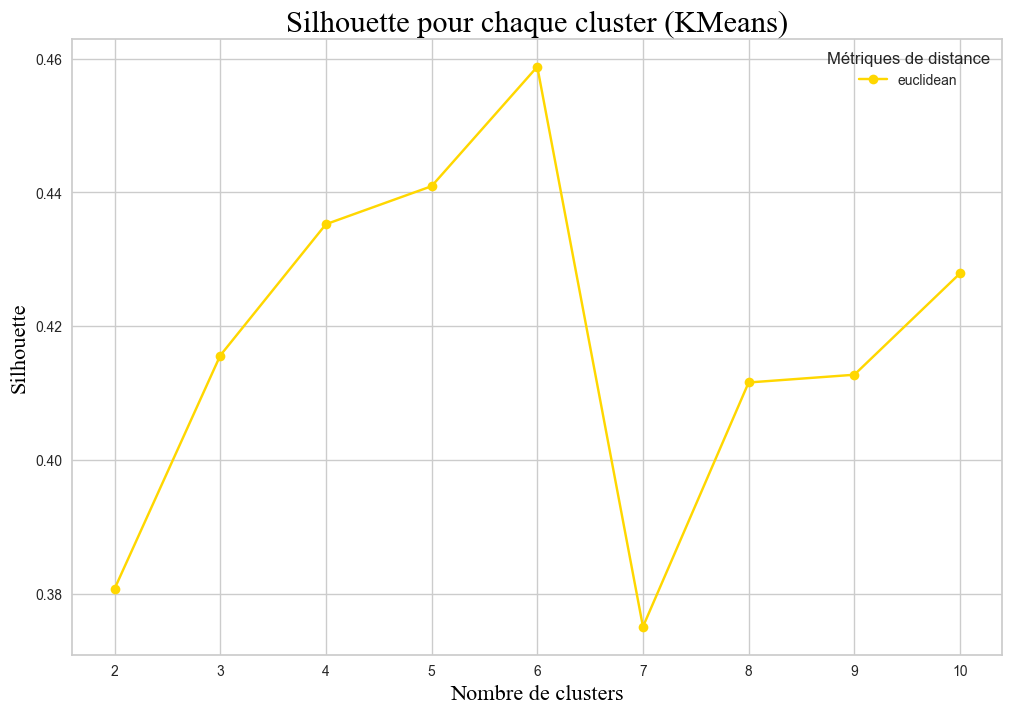

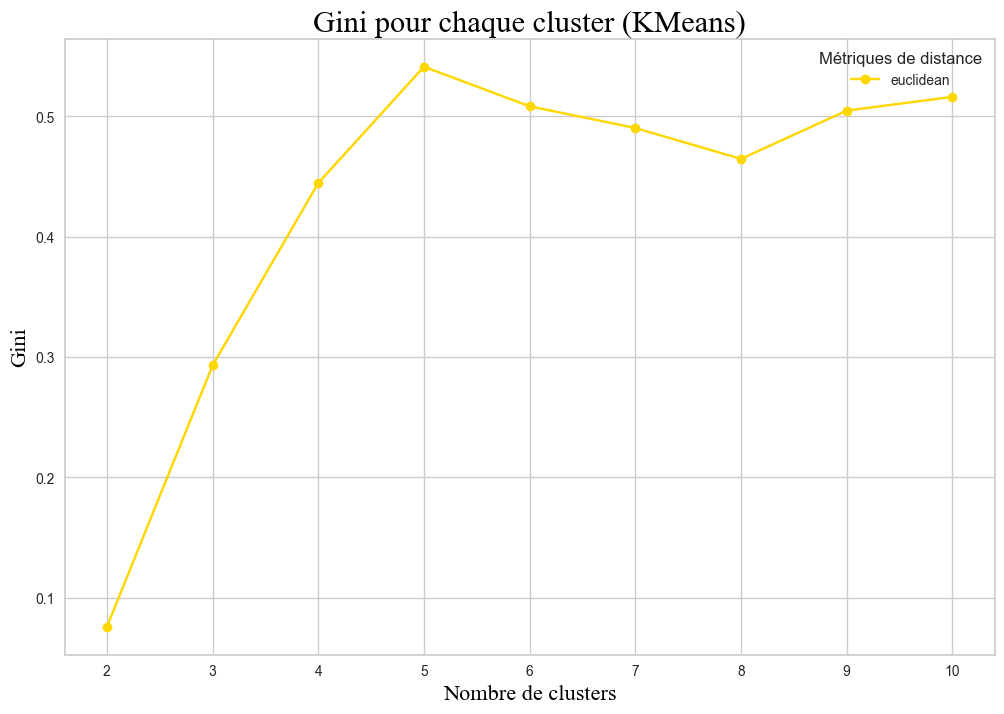

'Meilleur score de silhouette : '

,Hyperparametre,distance_metric,Coefficient silhouette,Indice Gini,Temps calcul,Nombre Clusters
4,{'n_clusters': 6},euclidean,0.45877,0.50835,0.33728,6


In [18]:
# Afficher X pour être sûr des données d'entrainement
display("Voici les données dans X :", X.head(3))
display(X.shape)

# Standardiser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Instancier l'estimateur et la classe ClusteringEstimator
kmeans = KMeans(n_init=10, random_state=42)
estimator_kmeans_3f = ClusteringEstimator(kmeans)

# Gammes d'hyperparamètres (nombre de clusters)
n_clusters_range = range(k_range[0], k_range[1] + 1)

# Gamme de distance_metric
distance_metric_range = ['euclidean']
# distance_metric_range = ['euclidean', 'manhattan', 'cosine', 'l1', 'l2', 'cityblock']

# POUR chaque distance_metric et chaque nombre de clusters
for distance_metric in distance_metric_range:
    for n_clusters in n_clusters_range:
    
        # Définir les hyperparamètres et entrainer l'estimateur
        estimator_kmeans_3f.set_hyperparameters({'n_clusters': n_clusters})
        estimator_kmeans_3f.fit(X_scaled, distance_metric=distance_metric)

# Afficher les graphiques
estimator_kmeans_3f.plot(plot_type='silhouette')

# Afficher les graphiques
estimator_kmeans_3f.plot(plot_type='gini')

# Afficher la ligne avec le meilleur score de silhouette
best_silhouette_score = estimator_kmeans_3f.performance_metrics.loc[estimator_kmeans_3f.performance_metrics['Coefficient silhouette'].idxmax()]

display("Meilleur score de silhouette : ", best_silhouette_score.to_frame().T)

Nous affichons les résultats du gridsearchCV pour inspection.

In [19]:
# Afficher les résultats silhouette en les classant dans l'ordre decroissant 
display(estimator_kmeans_3f.performance_metrics.sort_values(by='Coefficient silhouette', ascending=False).head(10))

# #to csv
# estimator_kmeans_3f.performance_metrics.to_csv('./data/estimator_kmeans_3f.csv', sep='\t', encoding='utf-8')

,Hyperparametre,distance_metric,Coefficient silhouette,Indice Gini,Temps calcul,Nombre Clusters
4,{'n_clusters': 6},euclidean,0.45877,0.50835,0.33728,6
3,{'n_clusters': 5},euclidean,0.44092,0.54125,0.30674,5
2,{'n_clusters': 4},euclidean,0.43523,0.44464,0.29450,4
8,{'n_clusters': 10},euclidean,0.42789,0.51620,0.44884,10
1,{'n_clusters': 3},euclidean,0.41561,0.29312,0.18861,3
7,{'n_clusters': 9},euclidean,0.41274,0.50478,0.43527,9
6,{'n_clusters': 8},euclidean,0.41158,0.46470,0.38375,8
0,{'n_clusters': 2},euclidean,0.38075,0.07601,0.29770,2
5,{'n_clusters': 7},euclidean,0.37509,0.49034,0.31899,7


Le coefficient de silhouette le plus élevé est obtenu avec **6 clusters**.

## <span style='background:yellow; color:black'>2/ Analyse de la qualité du clustering</span>

Nous créeons donc un modèle KMeans avec 6 clusters.

In [20]:
# Instancier l'estimateur
model_kmeans_3f = KMeans(n_init=10, random_state=42, n_clusters=6)

# Fit le modèle sur les données
model_kmeans_3f.fit(X_scaled)

KMeans(n_clusters=6, n_init=10, random_state=42)

### <span style='background:green; color:white'>a/ Visualisation de la silhouette</span>

Nous utilisons le visualisateur de silhouette pour visualiser les 6 clusters. 

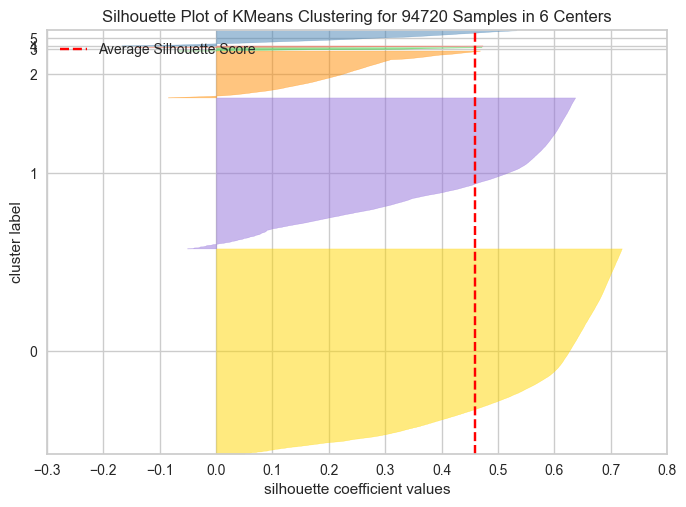

Cluster 5: 3401 observations
Cluster 4: 372 observations
Cluster 3: 737 observations
Cluster 2: 10486 observations
Cluster 1: 33786 observations
Cluster 0: 45938 observations


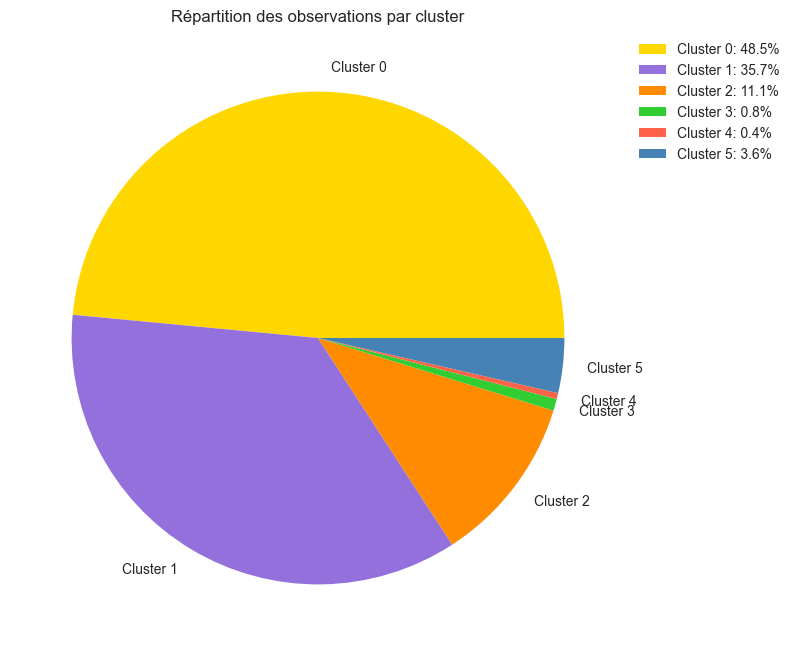

In [21]:
# Visualiser les 6 clusters
visualiser_clusters(X_scaled, n_clusters=6,random_state=42)

Nous remarquons qu'il y a un cluster qui détient près de la moitié des clients, un  cluster qui détient un tiers des clients, un  cluster qui détient un dixième des clients et les 3 autres clusters qui détiennent chacun moins de 4% des clients.

### <span style='background:green; color:white'>b/ Indice de Davies-Bouldin</span>

La qualité du clustering peut être évalué avec l'indice de Davies-Bouldin. Cet indice indique la "similarité" moyenne entre les clusters, la "similarité" étant une mesure qui compare la distance entre les clusters à la taille des clusters eux-mêmes.

Plus le score est faible, plus les clusters sont denses et séparés. Par exemple, lorsqu'il est :
- <1 : le clustering est considéré comme bon. 
- <2 : le clustering est considéré comme moyen. 
- \>3 : le clustering est considéré comme mauvais. 

In [22]:
# Score de Davies-Bouldin
db_score = davies_bouldin_score(X_scaled, model_kmeans_3f.labels_)
print(f"Le score de Davies-Bouldin est : {round(db_score, 2)}")

Le score de Davies-Bouldin est : 0.84


Le score de Davies-Bouldin évoque un bon clustering. 

### <span style='background:green; color:white'>c/ Plot 3D des clusters</span>

Nous concatenons les données avec les labels de cluster.

In [23]:
# Dataframe avec la feature des clusters
df_rfm_cluster = pd.concat([X, pd.Series(model_kmeans_3f.labels_, index=X.index, name='Cluster')], axis=1)

# Affichage
display(df_rfm_cluster.head(3))

,recence,frequence,montant,Cluster
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90,0
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19,0
0000f46a3911fa3c0805444483337064,541,1,86.22,1


Nous affichons un plot 3D des clusters.

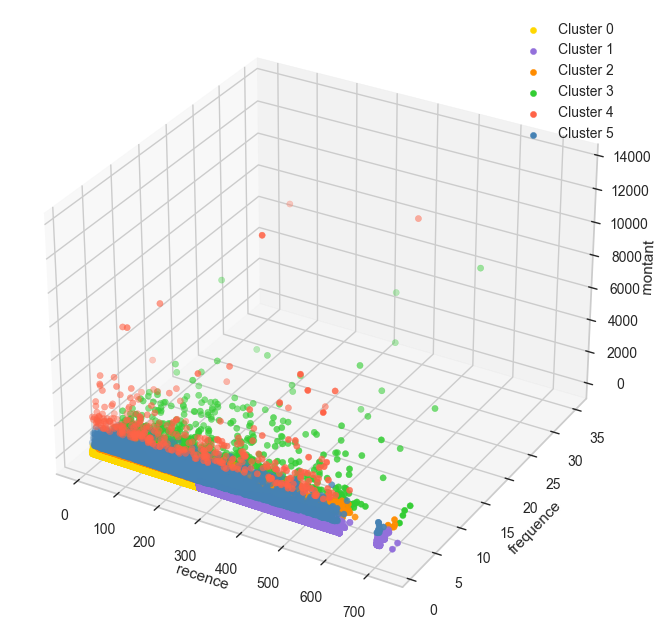

In [24]:
# df de travail
df = df_rfm_cluster

# Créer une figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Créer une liste de labels pour les clusters
cluster_labels = sorted(df['Cluster'].unique())

# Tracer les points pour chaque cluster
for cluster in cluster_labels:
    mask = df['Cluster'] == cluster
    ax.scatter(df[mask]['recence'], df[mask]['frequence'], df[mask]['montant'], c=colors_list[cluster], label=f'Cluster {cluster}')

# Titre des axes
ax.set_xlabel('recence')
ax.set_ylabel('frequence')
ax.set_zlabel('montant')

# Ajouter une légende
ax.legend()
plt.show()

### <span style='background:green; color:white'>d/ Distribution et moyenne par cluster</span>

Nous affichons les boxplots des clusters pour chaque feature afin de vérifier la pertinence du clustering.

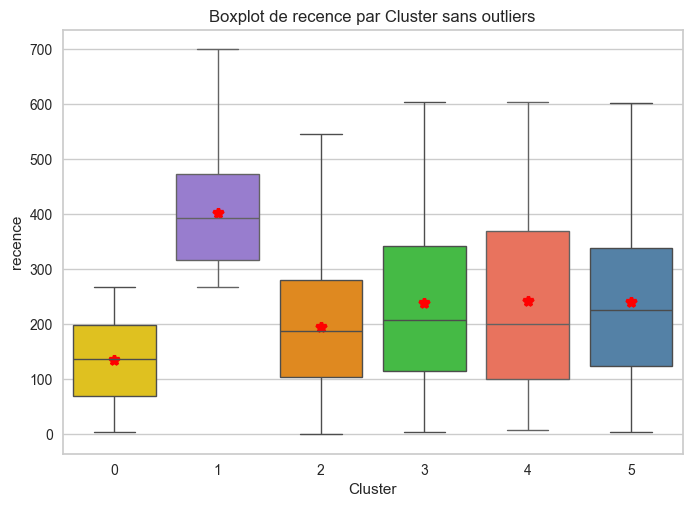

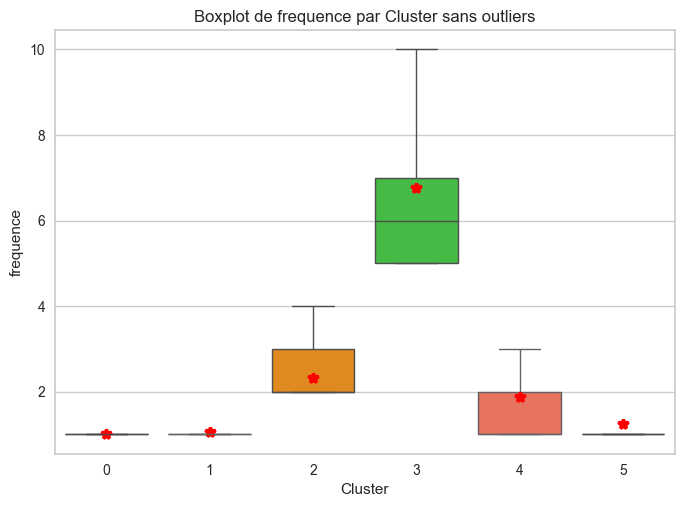

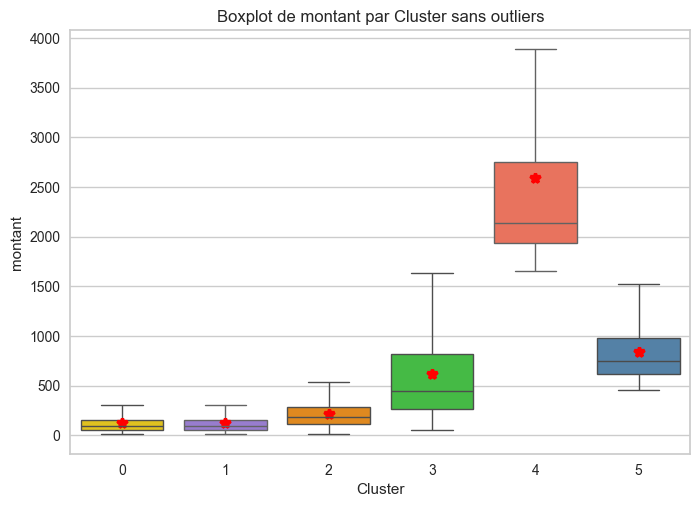

In [25]:
# Afficher les boxplots
afficher_boxplot(df_rfm_cluster, cluster_col_nom='Cluster', outliers=False)

Nous affichons la moyenne des clusters pour chaque feature afin de vérifier la pertinence du clustering.

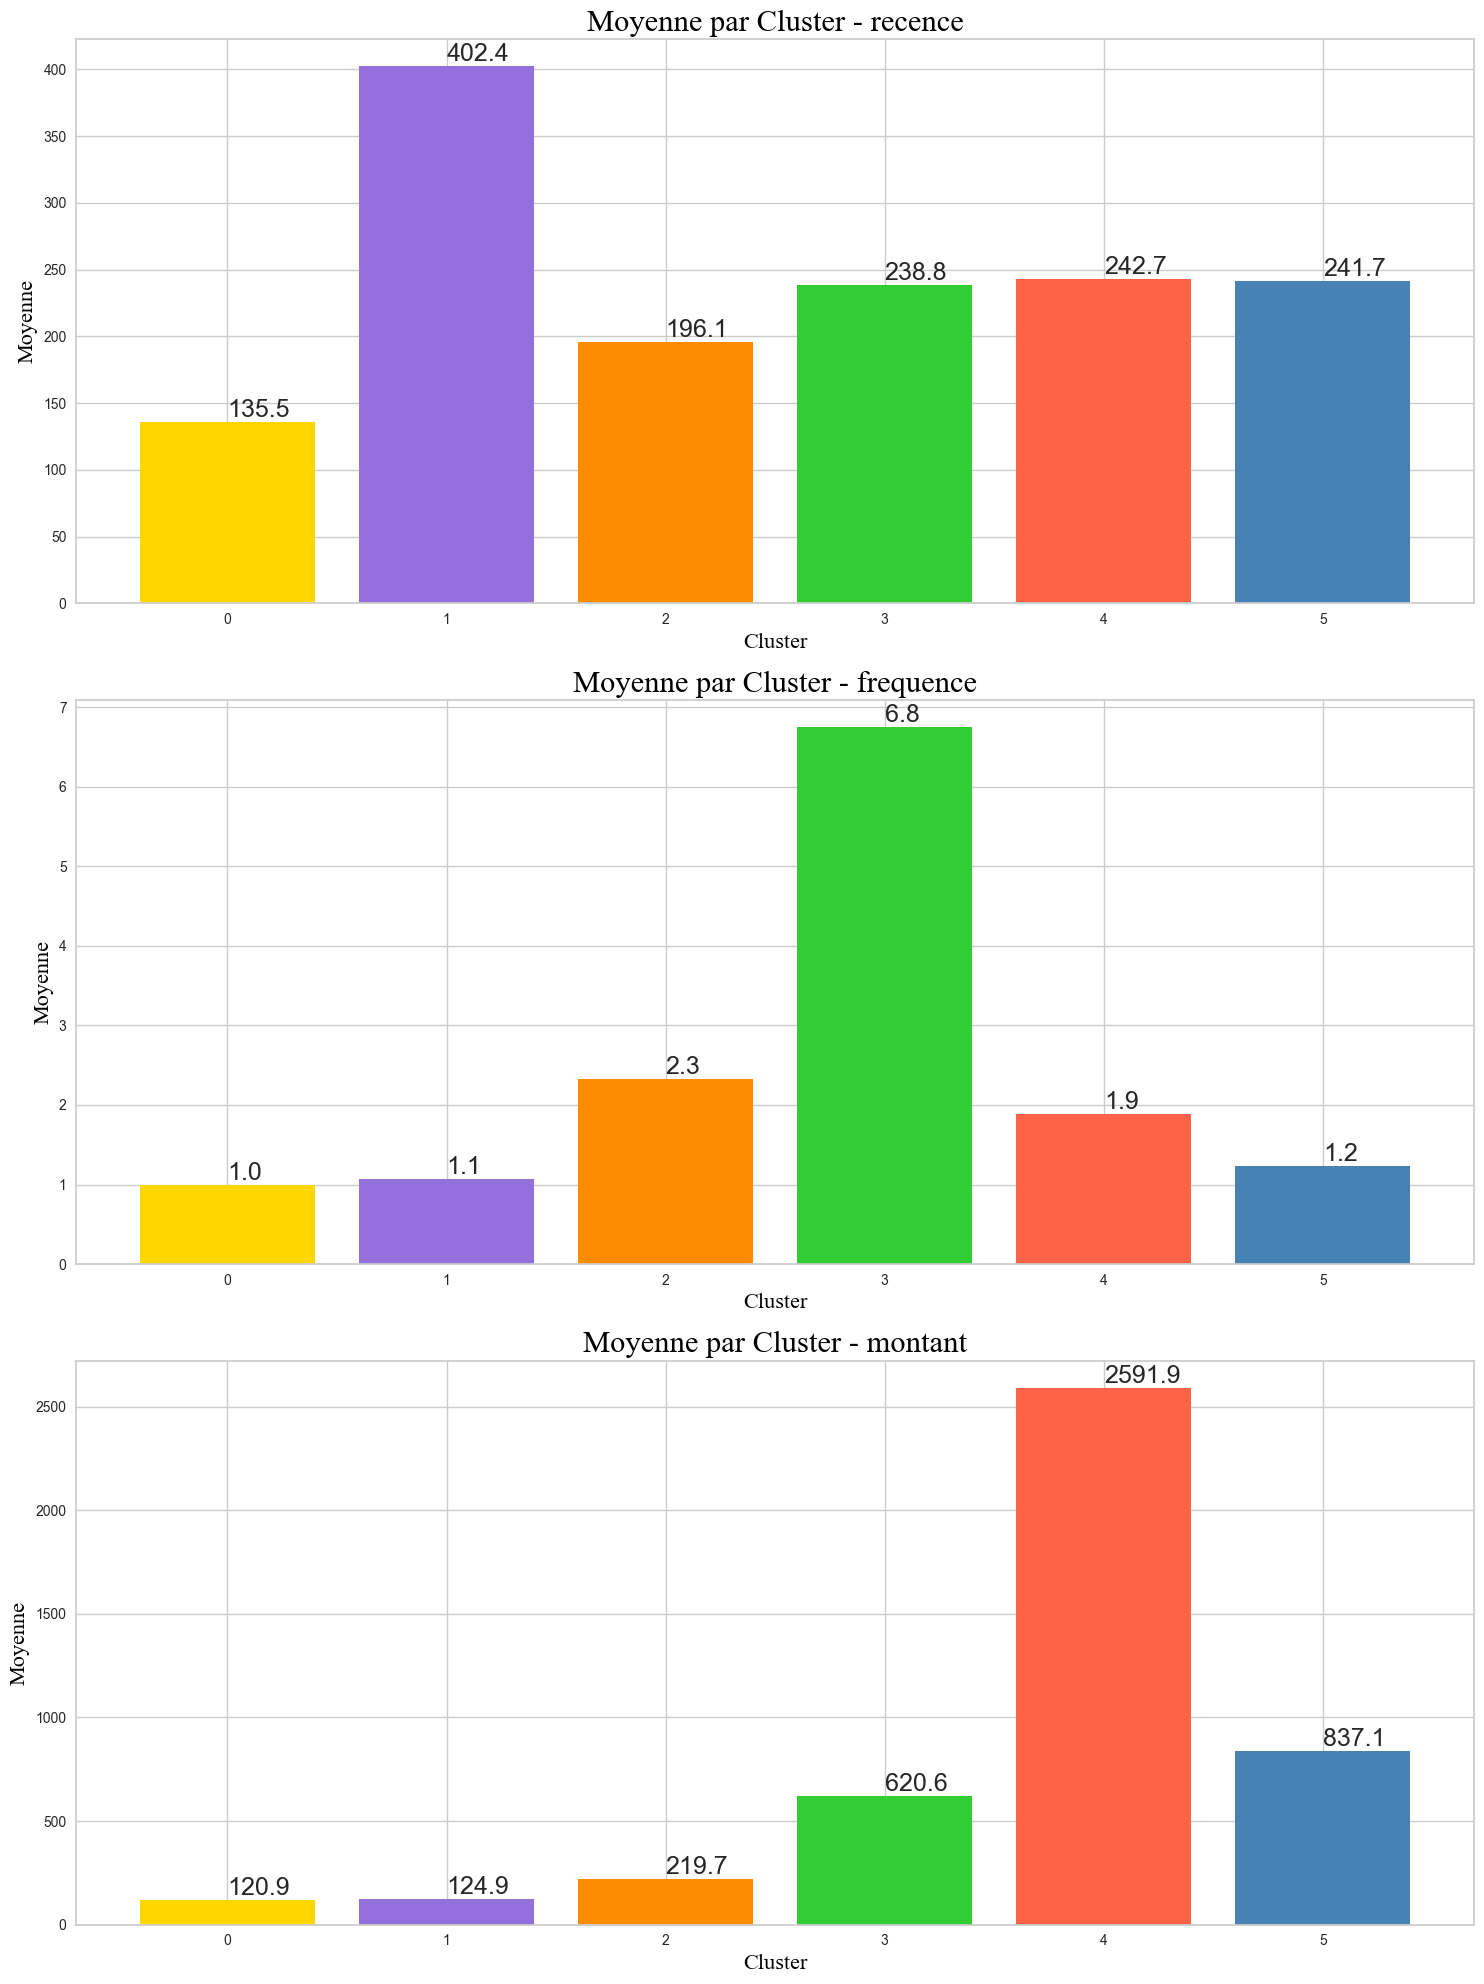

In [26]:
# Tracer la moyenne par cluster pour chaque feature
moyenne_par_cluster = tracer_moyenne_par_cluster(df_rfm_cluster)

Nous remarquons qu'il y a 3 clusters qui se distinguent des autres par une récence, une fréquence ou un montant d'achat plus élevé.

### <span style='background:green; color:white'>e/ Radar par cluster</span>

Nous normalisons les moyennes des features pour pouvoir les comparer entre les clusters. 

In [27]:
# Créer un scaler
scaler = MinMaxScaler()

# Ajuster et transformer les données
moyenne_par_cluster_scaled = scaler.fit_transform(moyenne_par_cluster)

# Convertir le résultat en DataFrame
moyenne_par_cluster_scaled = pd.DataFrame(moyenne_par_cluster_scaled, columns=moyenne_par_cluster.columns)

# Affichage
display(moyenne_par_cluster_scaled)

,recence,frequence,montant
0,0.00000,0.00000,0.00000
1,1.00000,0.01127,0.00163
2,0.22699,0.23112,0.04001
3,0.38704,1.00000,0.20223
4,0.40163,0.15369,1.00000
5,0.39780,0.04078,0.28986


Nous affichons un radar pour chaque cluster.

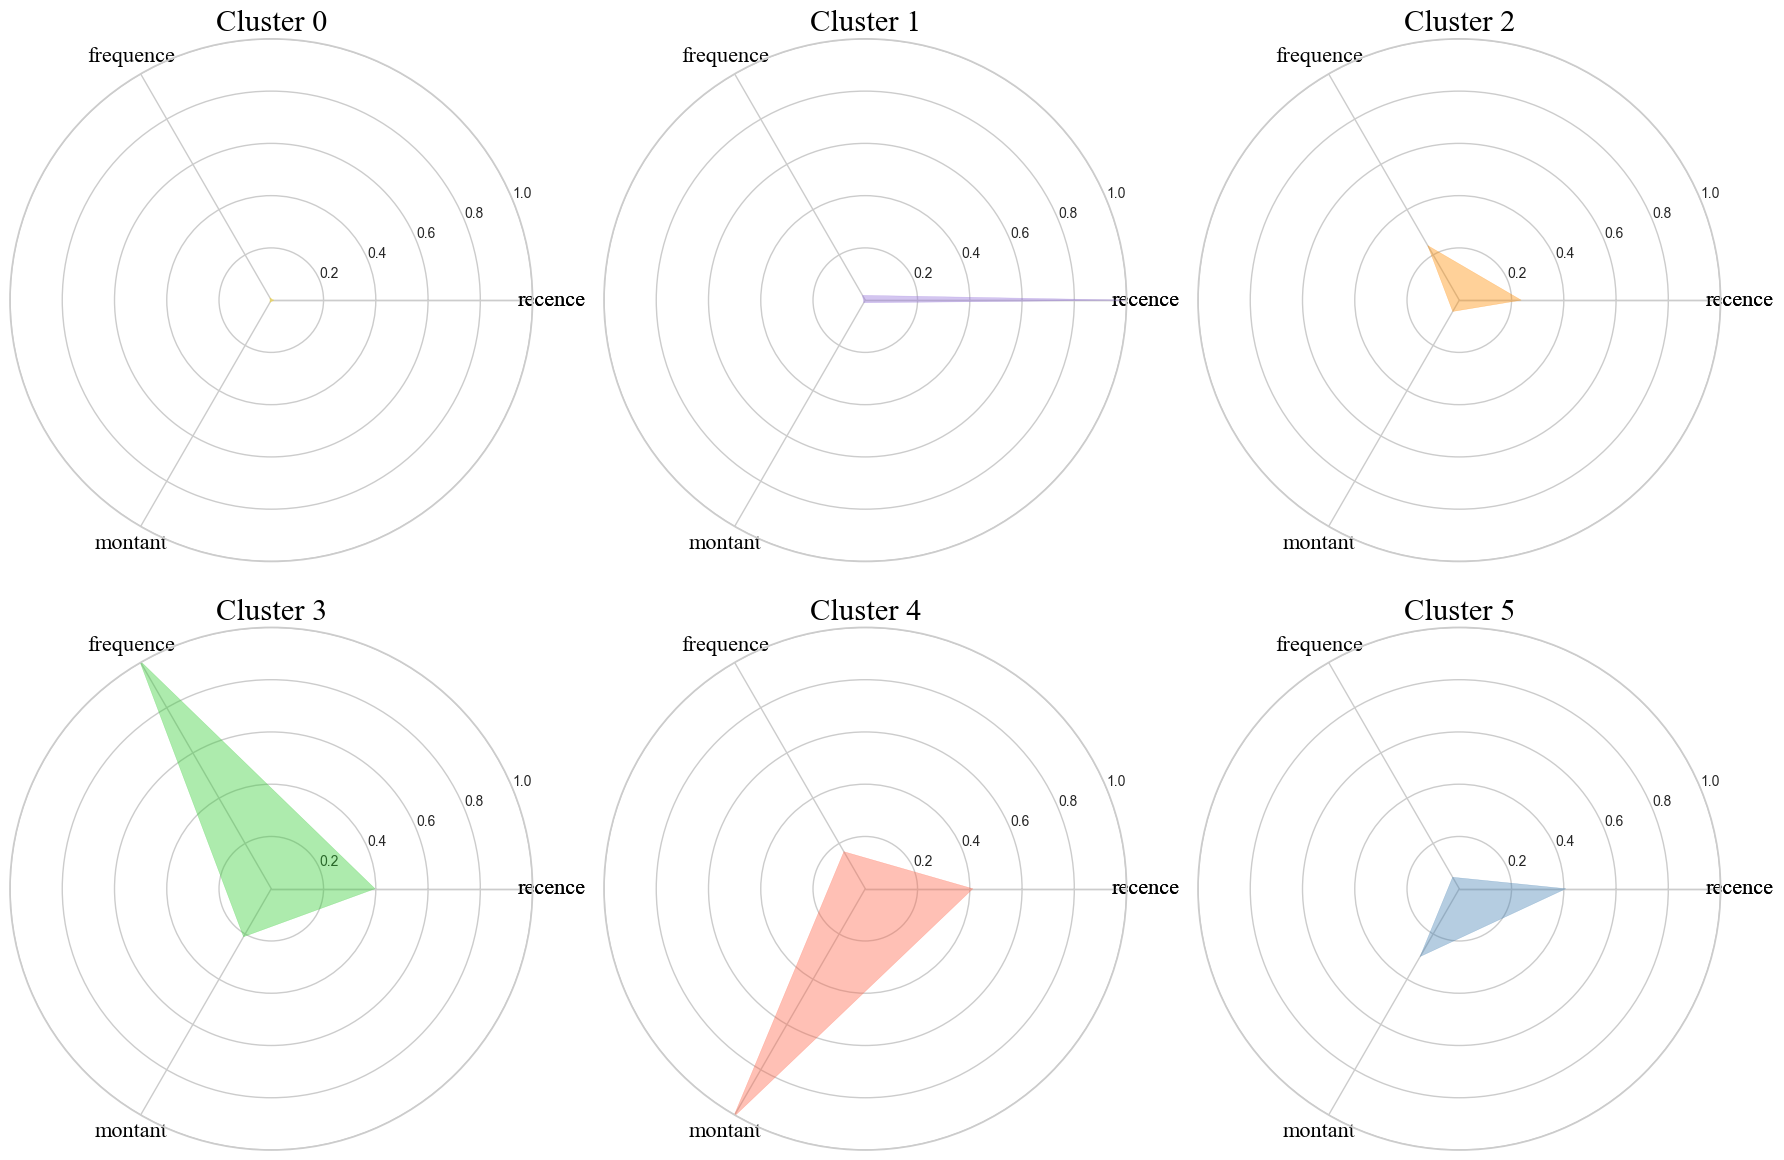

In [28]:
# Tracer un graphique radar pour chaque cluster
tracer_radar_par_cluster(moyenne_par_cluster_scaled, alpha=0.40)

<div class="alert alert-block alert-info"><b>Bilan: </b> <br>
Le clustering de la RFM avec 6 clusters est composé de : <br>
<br>
- Cluster 0 : client (49%) qui ont fait un seul achat dans les 6 derniers mois (135 jours) de faible montant (120 R$). <br>
<br>
- Cluster 1 : client (36%) qui ont fait un seul achat il y a plus d'un an (402 jours) de faible montant (125 R$). <br>
<br>
- Cluster 2 : client (11%) qui ont fait quelques achats (2 ou 3) dans l'année (196 jours) de faible montant (220 R$ cumulés). <br>
<br>
- Cluster 5 : client (4%) qui ont fait un seul achat dans l'année (242 jours), d'un montant intermédiaire (840 R$ R$). <br>
<br>
- Cluster 3 : client (<1%) qui ont fait beaucoup d'achat (env. 7) dans l'année (239 jours), d'un faible montant (620 R$ cumulés). <br>
<br>
- Cluster 4 : client (<0,5%) qui ont fait quelques achats (1 à 2) dans l'année (243 jours), d'un montant élevé (2_600 R$). <br>

# <span style='background:blue'>Etape 2 : K-mean clustering RFM + Satisfaction</span>

Nous réalisons le même travail de segmentation que précédemment mais en ajoutant la variable satisfaction.

Nous selectionnons donc la RFM + Satisfaction pour réaliser la segmentation des clients.

In [29]:
# isoler les features de la RFM	
rfms = df_data

# Afficher aperçu et dimension du df
display(rfms.head(3))
display(rfms.shape)

# Données de travail
X = rfms

,recence,frequence,montant,satisfaction
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19,4.0
0000f46a3911fa3c0805444483337064,541,1,86.22,3.0


(94720, 4)

## <span style='background:yellow; color:black'>1/ Détermination du nombre de cluster</span>

### <span style='background:green; color:white'>Score Silhouette</span>

La métrique de **silhouette** calcule la distance moyenne entre chaque point et tous les autres points du même cluster. Cette distance est ensuite comparée à la distance moyenne entre le point et tous les points d'un autre cluster. La silhouette est comprise entre -1 et 1. Plus la valeur est proche de 1, plus le point est proche des autres points de son cluster et éloigné des points des autres clusters.

'Voici les données dans X :'

,recence,frequence,montant,satisfaction
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19,4.0
0000f46a3911fa3c0805444483337064,541,1,86.22,3.0


(94720, 4)

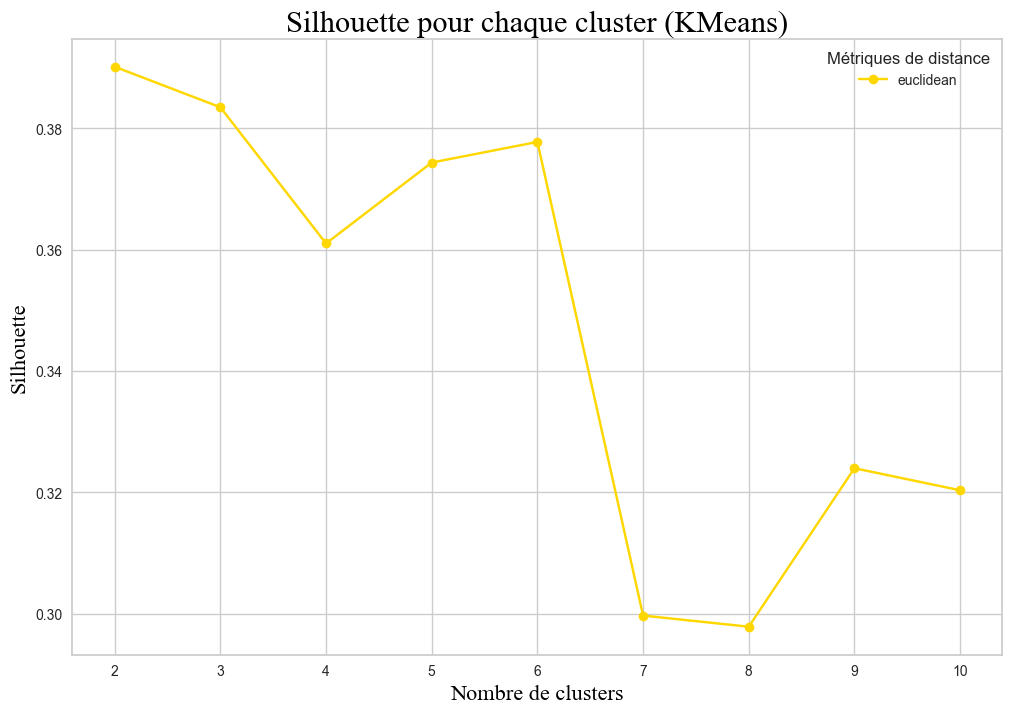

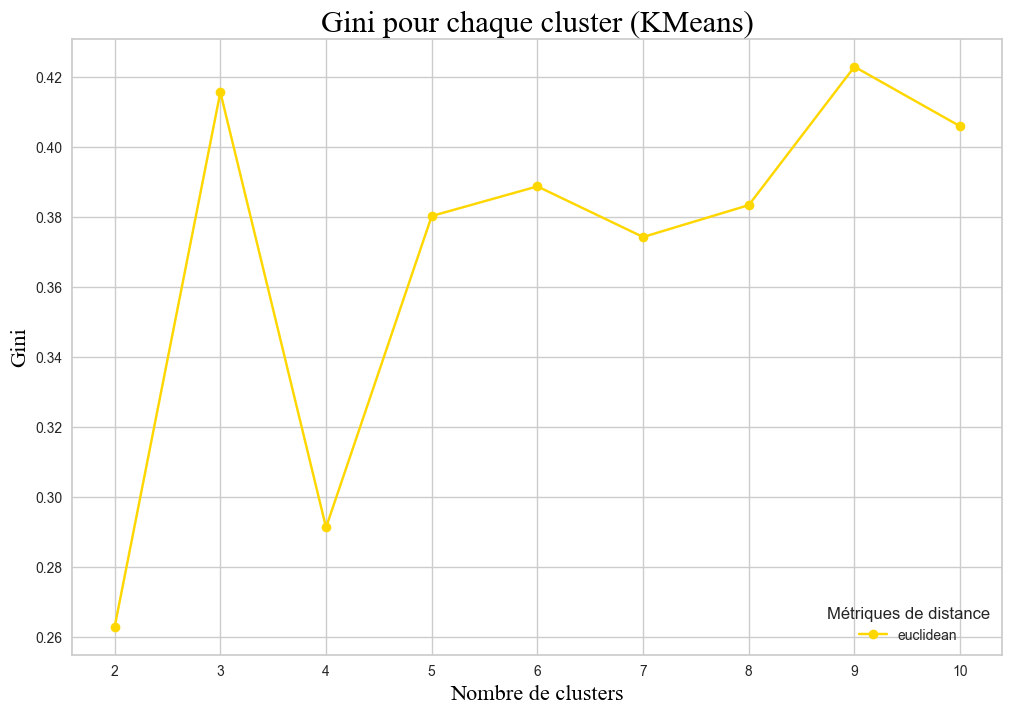

'Meilleur score de silhouette : '

,Hyperparametre,distance_metric,Coefficient silhouette,Indice Gini,Temps calcul,Nombre Clusters
0,{'n_clusters': 2},euclidean,0.39016,0.26292,0.14872,2


In [30]:
# Afficher X pour être sûr des données d'entrainement
display("Voici les données dans X :", X.head(3))
display(X.shape)

# Standardiser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Instancier l'estimateur et la classe ClusteringEstimator
kmeans = KMeans(n_init=10, random_state=42)
estimator_kmeans_4f = ClusteringEstimator(kmeans)

# Gammes d'hyperparamètres (nombre de clusters)
n_clusters_range = range(k_range[0], k_range[1] + 1)

# Gamme de distance_metric
distance_metric_range = ['euclidean']
# distance_metric_range = ['euclidean', 'manhattan', 'cosine', 'l1', 'l2', 'cityblock']

# POUR chaque distance_metric et chaque nombre de clusters
for distance_metric in distance_metric_range:
    for n_clusters in n_clusters_range:
    
        # Définir les hyperparamètres et entrainer l'estimateur
        estimator_kmeans_4f.set_hyperparameters({'n_clusters': n_clusters})
        estimator_kmeans_4f.fit(X_scaled, distance_metric=distance_metric)

# Afficher les graphiques
estimator_kmeans_4f.plot(plot_type='silhouette')

# Afficher les graphiques
estimator_kmeans_4f.plot(plot_type='gini')

# Afficher la ligne avec le meilleur score de silhouette
best_silhouette_score = estimator_kmeans_4f.performance_metrics.loc[estimator_kmeans_4f.performance_metrics['Coefficient silhouette'].idxmax()]

display("Meilleur score de silhouette : ", best_silhouette_score.to_frame().T)

Nous affichons les résultats du gridsearchCV pour inspection.

In [31]:
# Afficher les résultats silhouette en les classant dans l'ordre decroissant 
display(estimator_kmeans_4f.performance_metrics.sort_values(by='Coefficient silhouette', ascending=False).head(10))

# #to csv
# estimator_kmeans_4f.performance_metrics.to_csv('./data/estimator_kmeans_4f.csv', sep='\t', encoding='utf-8')

,Hyperparametre,distance_metric,Coefficient silhouette,Indice Gini,Temps calcul,Nombre Clusters
0,{'n_clusters': 2},euclidean,0.39016,0.26292,0.14872,2
1,{'n_clusters': 3},euclidean,0.38348,0.41568,0.16652,3
4,{'n_clusters': 6},euclidean,0.37776,0.38876,0.27252,6
3,{'n_clusters': 5},euclidean,0.37437,0.38030,0.21684,5
2,{'n_clusters': 4},euclidean,0.36103,0.29130,0.19990,4
7,{'n_clusters': 9},euclidean,0.32400,0.42296,0.55891,9
8,{'n_clusters': 10},euclidean,0.32036,0.40594,0.69099,10
5,{'n_clusters': 7},euclidean,0.29972,0.37430,0.35343,7
6,{'n_clusters': 8},euclidean,0.29788,0.38341,0.45742,8


Les 2 meilleurs scores de silhouette sont obtenus avec 2 et 3 clusters, mais ces segmentations ne sont pas assez fines pour notre client. Nous prennons donc le 3ème meilleur score de silhouette qui utilise **6 clusters**.

## <span style='background:yellow; color:black'>2/ Analyse de la qualité du clustering</span>

Nous créeons donc un modèle KMeans avec 6 clusters.

In [32]:
# Instancier l'estimateur
model_kmeans_4f = KMeans(n_init=10, random_state=42, n_clusters=6)

# Fit le modèle sur les données
model_kmeans_4f.fit(X_scaled)

KMeans(n_clusters=6, n_init=10, random_state=42)


### <span style='background:green; color:white'>a/ Visualisation de la silhouette</span>

Nous utilisons le visualisateur de silhouette pour visualiser les 6 clusters. 

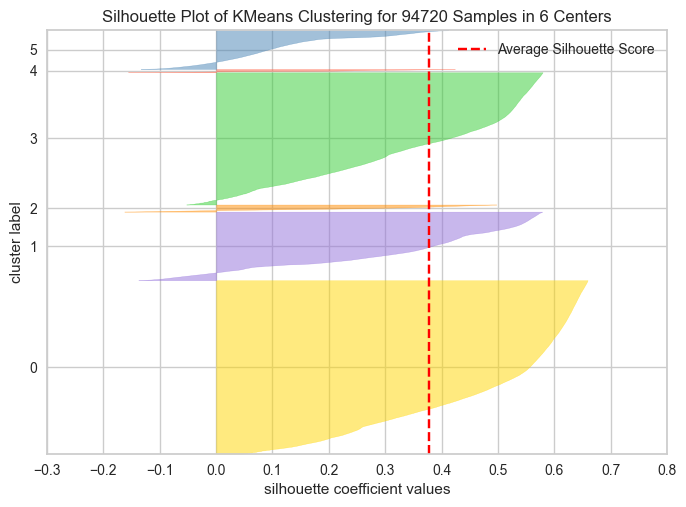

Cluster 5: 8650 observations
Cluster 4: 745 observations
Cluster 3: 29578 observations
Cluster 2: 1582 observations
Cluster 1: 15346 observations
Cluster 0: 38819 observations


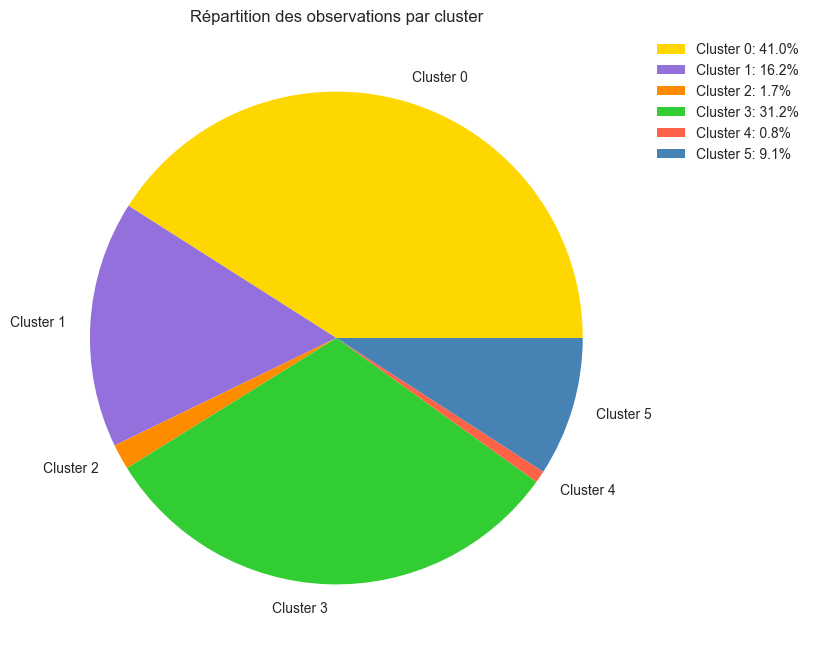

In [33]:
# Visualiser les 6 clusters
visualiser_clusters(X_scaled, n_clusters=6,random_state=42)

### <span style='background:green; color:white'>b/ Indice de Davies-Bouldin</span>

La qualité du clustering peut être évalué avec l'indice de Davies-Bouldin. Cet indice indique la "similarité" moyenne entre les clusters, la "similarité" étant une mesure qui compare la distance entre les clusters à la taille des clusters eux-mêmes.

Plus le score est faible, plus les clusters sont denses et séparés. Par exemple, lorsqu'il est :
- <1 : le clustering est considéré comme bon. 
- <2 : le clustering est considéré comme moyen. 
- \>3 : le clustering est considéré comme mauvais. 

In [34]:
# Score de Davies-Bouldin
db_score = davies_bouldin_score(X_scaled, model_kmeans_4f.labels_)
print(f"Le score de Davies-Bouldin est : {round(db_score, 2)}")

Le score de Davies-Bouldin est : 0.97


Le score de Davies-Bouldin évoque un bon clustering.

### <span style='background:green; color:white'>c/ Plot 3D des clusters</span>

Nous concatenons les données avec les labels de cluster.

In [35]:
# Dataframe avec la feature des clusters
df_rfms_cluster = pd.concat([X, pd.Series(model_kmeans_4f.labels_, index=X.index, name='Cluster')], axis=1)

# Affichage
display(df_rfms_cluster.head(3))

,recence,frequence,montant,satisfaction,Cluster
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90,5.0,0
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19,4.0,0
0000f46a3911fa3c0805444483337064,541,1,86.22,3.0,3


Nous affichons un plot 3D des clusters.

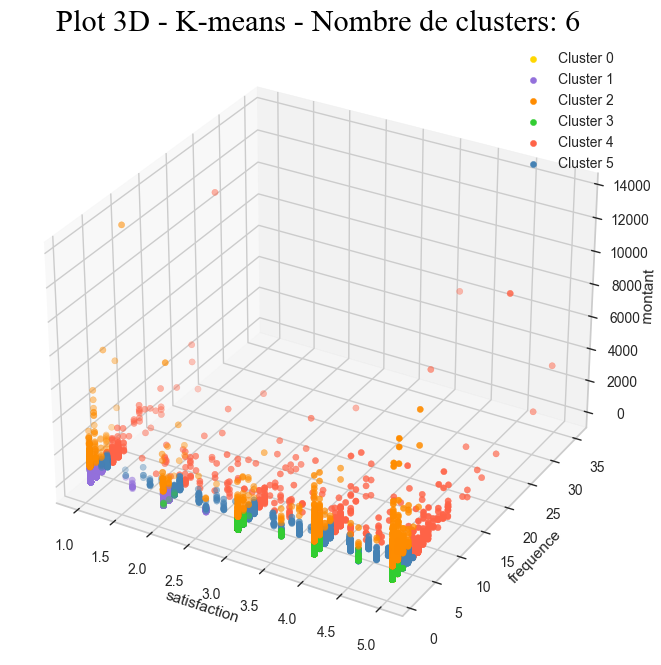

In [36]:
# df de travail
df = df_rfms_cluster

# Créer une figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Créer une liste de labels pour les clusters
cluster_labels = sorted(df['Cluster'].unique())

# Tracer les points pour chaque cluster
for cluster in cluster_labels:
    mask = df['Cluster'] == cluster
    ax.scatter(df[mask]['satisfaction'], df[mask]['frequence'], df[mask]['montant'], c=colors_list[cluster], label=f'Cluster {cluster}')

# Titre des axes
ax.set_title('Plot 3D - K-means - Nombre de clusters: %d' % len(cluster_labels), fontdict=font_title)
ax.set_xlabel('satisfaction')
ax.set_ylabel('frequence')
ax.set_zlabel('montant')

# Ajouter une légende
ax.legend()
plt.show()

### <span style='background:green; color:white'>d/ Distribution et moyenne par cluster</span>

Nous affichons les boxplots des clusters pour chaque feature afin de vérifier la pertinence du clustering.

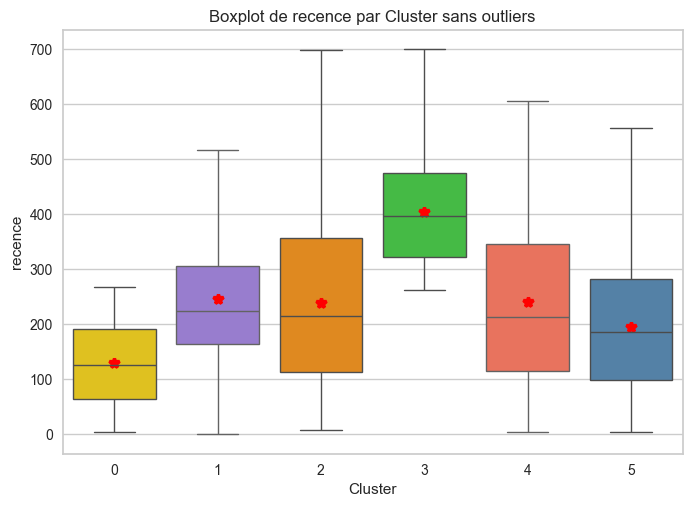

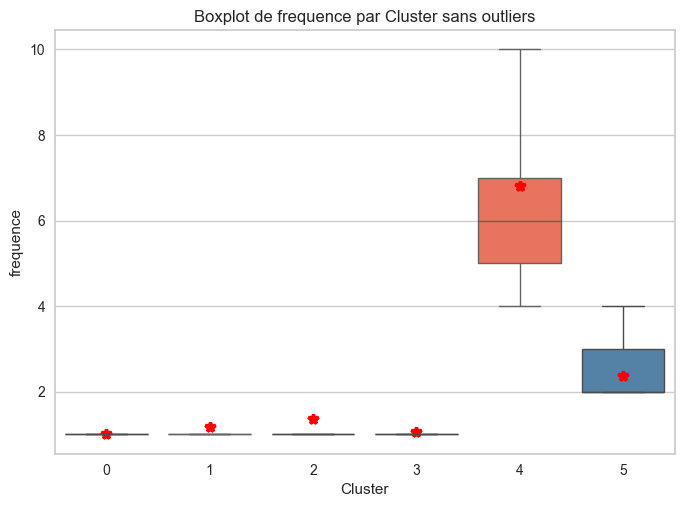

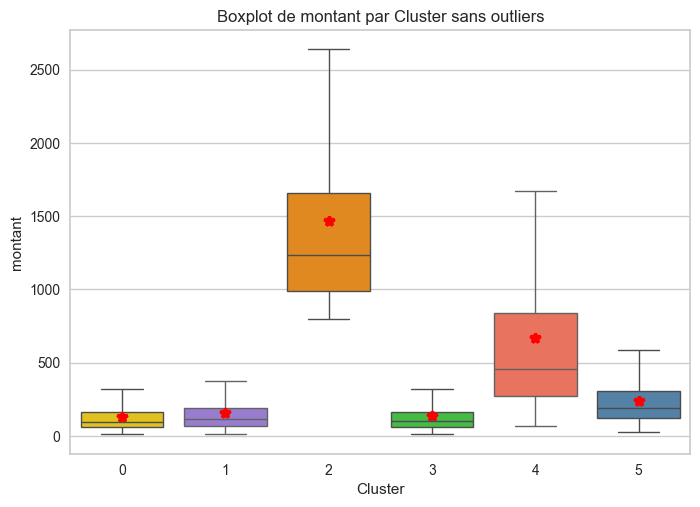

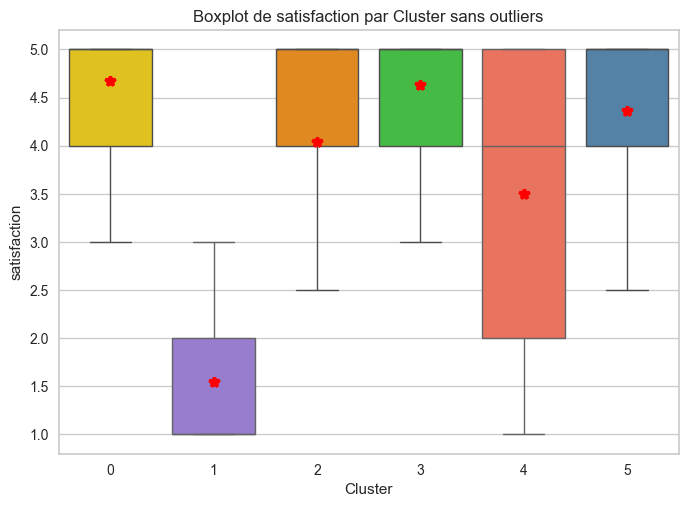

In [37]:
# Afficher les boxplots
afficher_boxplot(df_rfms_cluster, cluster_col_nom='Cluster', outliers=False)

Nous affichons la moyenne des clusters pour chaque feature afin de vérifier la pertinence du clustering.

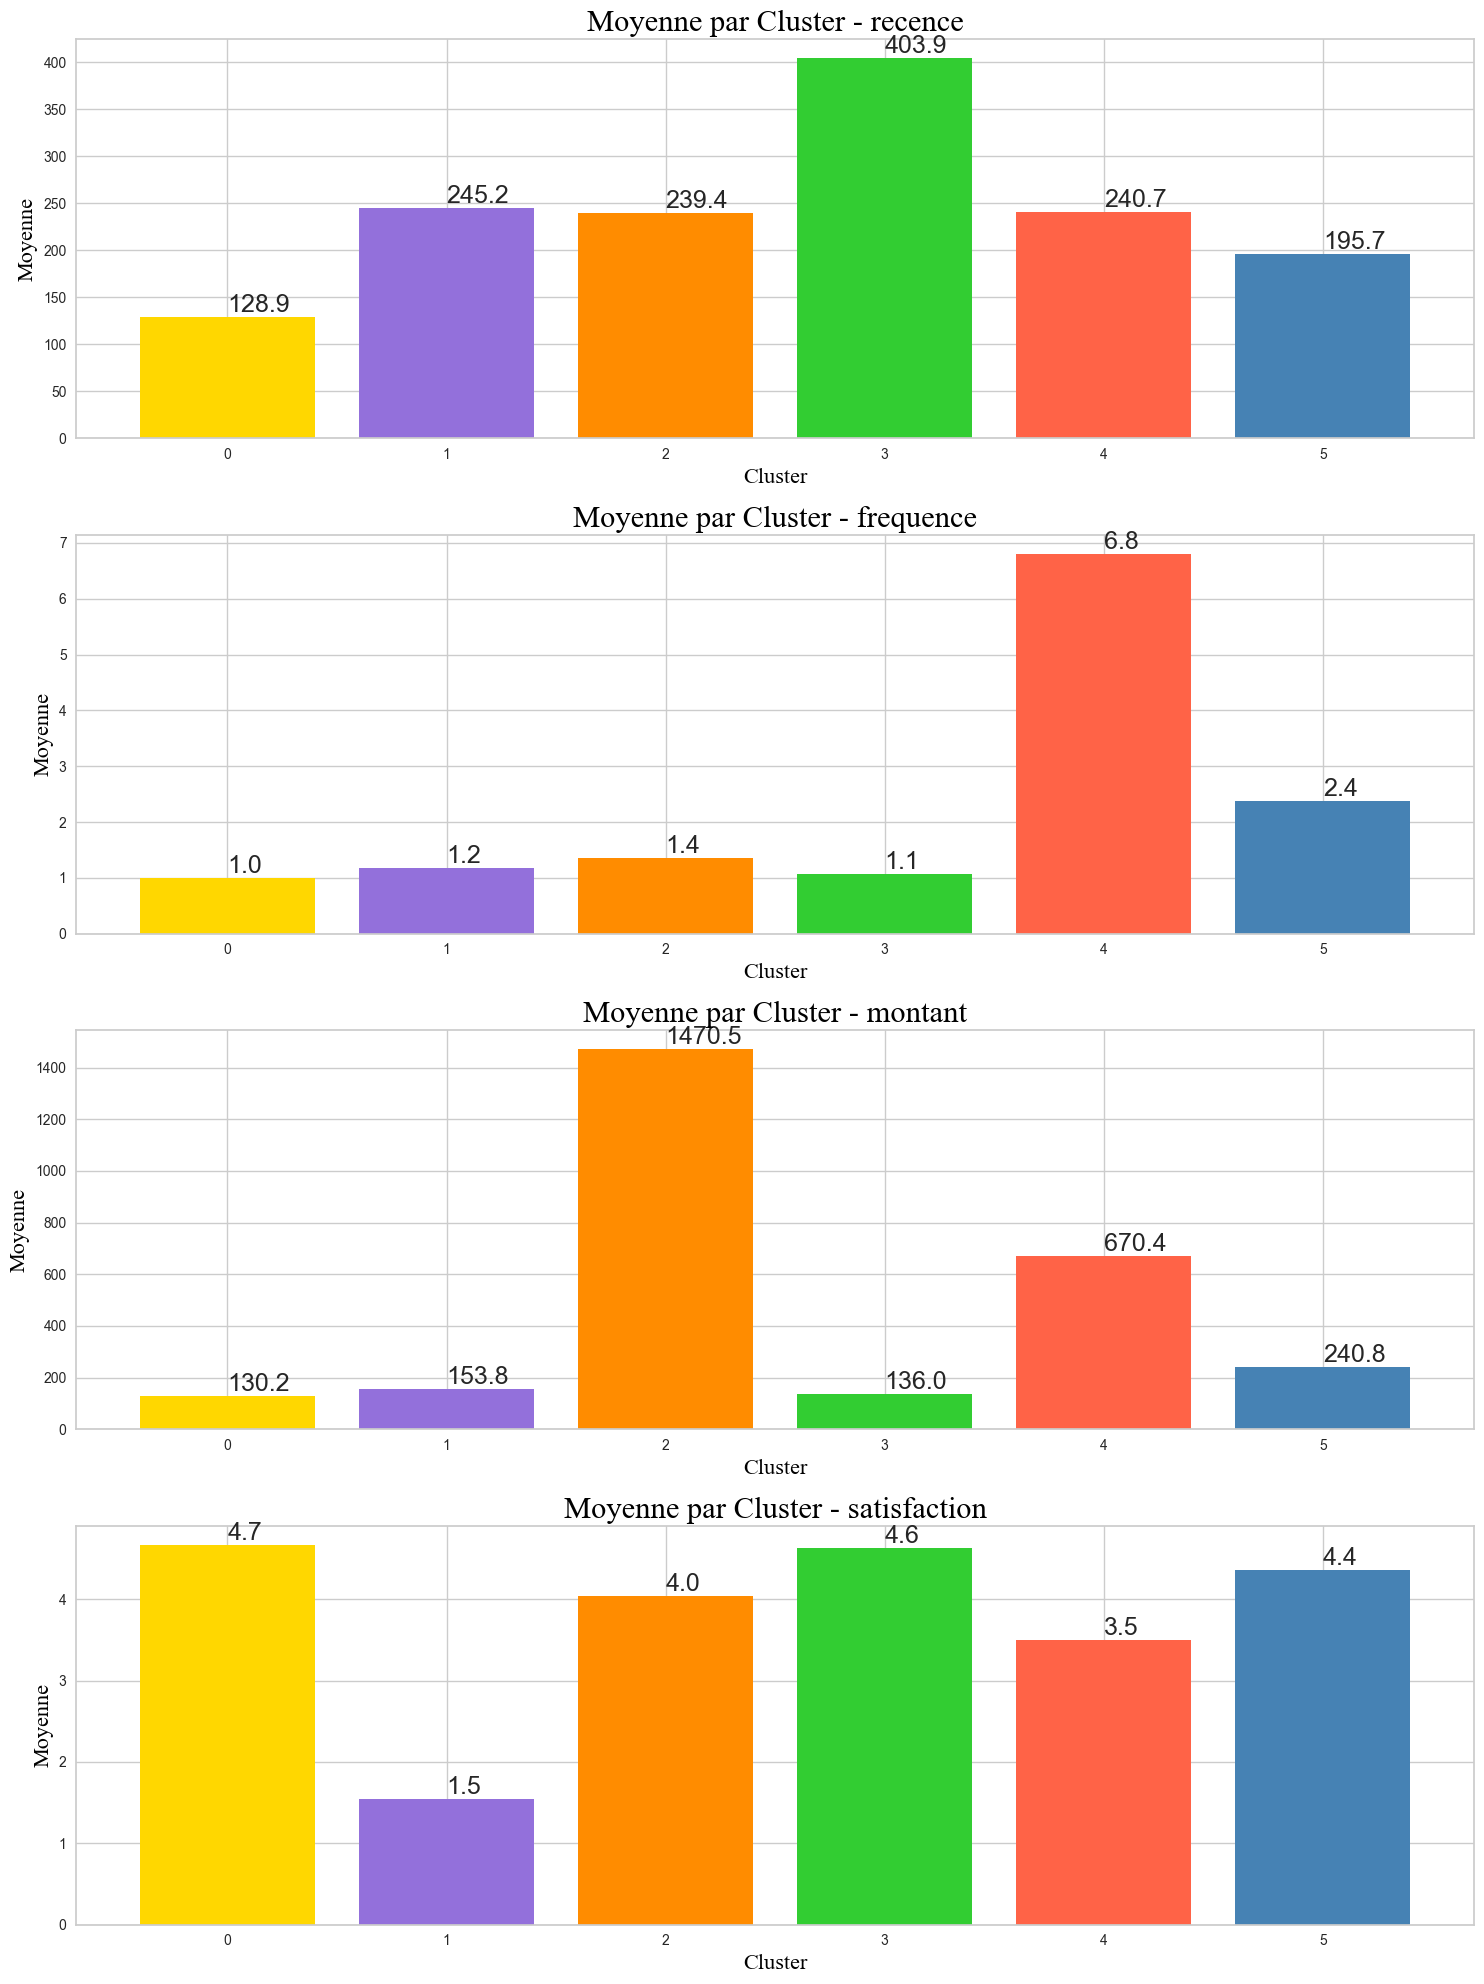

In [38]:
# Tracer la moyenne par cluster pour chaque feature
moyenne_par_cluster = tracer_moyenne_par_cluster(df_rfms_cluster)

Nous remarquons qu'il y a 3 clusters qui se distinguent des autres par une récence, une fréquence ou un montant d'achat plus élevé, un cluster se démarque par une satisfaction plus basse.

### <span style='background:green; color:white'>e/ Radar par cluster</span>

Nous normalisons les moyennes des features pour pouvoir les comparer entre les clusters. 

In [39]:
# Créer un scaler
scaler = MinMaxScaler()

# Ajuster et transformer les données
moyenne_par_cluster_scaled = scaler.fit_transform(moyenne_par_cluster)

# Convertir le résultat en DataFrame
moyenne_par_cluster_scaled = pd.DataFrame(moyenne_par_cluster_scaled, columns=moyenne_par_cluster.columns)

# Affichage
display(moyenne_par_cluster_scaled)

,recence,frequence,montant,satisfaction
0,0.00000,0.00000,0.00000,1.00000
1,0.42287,0.03079,0.01757,0.00000
2,0.40176,0.06215,1.00000,0.79928
3,1.00000,0.01140,0.00428,0.98713
4,0.40662,1.00000,0.40304,0.62412
5,0.24289,0.23689,0.08252,0.90280


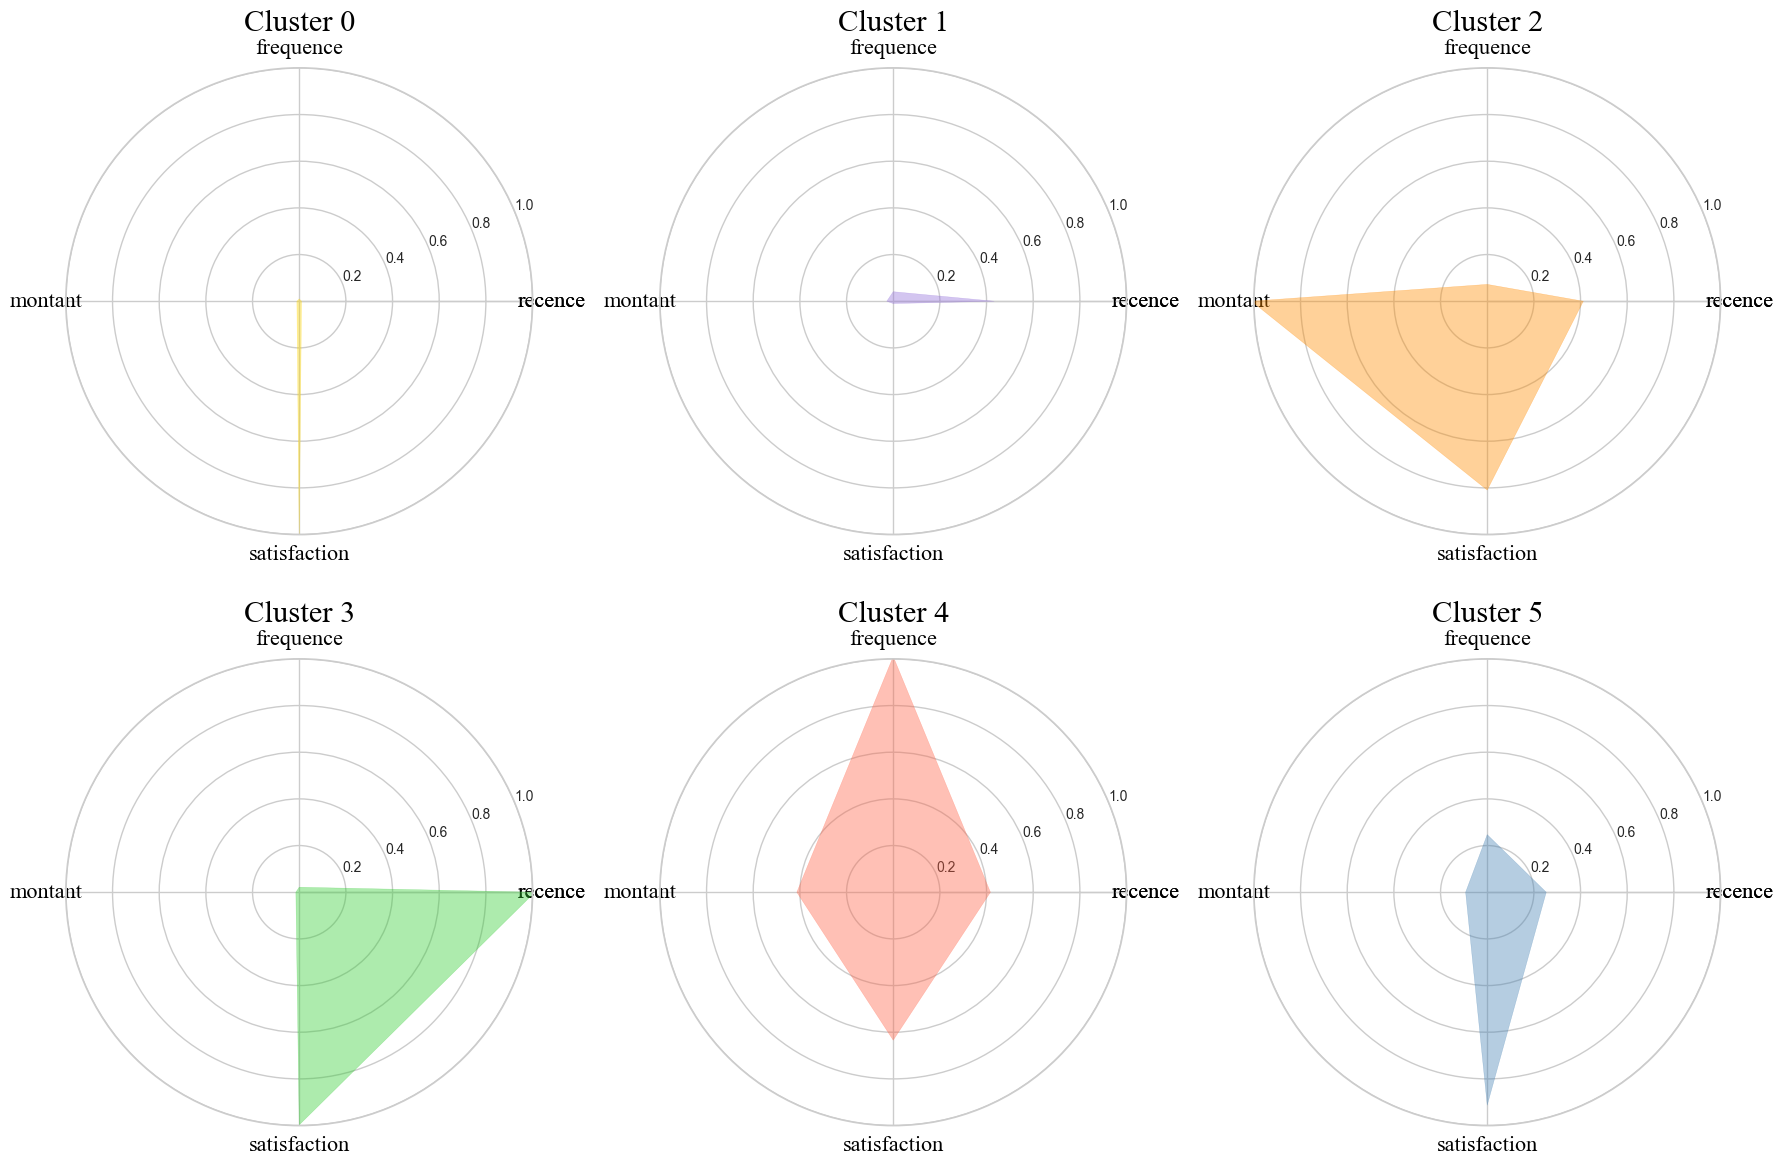

In [40]:
# Tracer un graphique radar pour chaque cluster
tracer_radar_par_cluster(moyenne_par_cluster_scaled, alpha=0.40)

<div class="alert alert-block alert-info"><b>Bilan: </b> <br>
Le clustering de la RFMS avec 6 clusters est composé de : <br>
<br>
- Cluster 0 : client (41%) qui ont fait un seul achat dans les 6 derniers mois (130 jours) de faible montant (env. 129 R$) et qui sont très satisfaits (5/5). <br>
<br>
- Cluster 3 : client (31%) qui ont fait un seul achat il y a plus d'un an (404 jours) de faible montant (136 R$) et qui sont très satisfait (5/5). <br>
<br>
- Cluster 1 : client (16%) qui ont fait un seul achat dans l'année (245 jours) de faible montant (154 R$) et qui ne sont pas du tout satisfait (1/5). <br>
<br>
- Cluster 5 : client (9%) qui ont fait quelques achats (2-3) dans l'année (196 jours), de faible montant (240 R$ R$) et qui sont satisfait (4/5). <br>
<br>
- Cluster 2 : client (<2%) qui ont fait un seul achat dans l'année (239 jours), d'un montant élevé (1_470 R$) et qui sont satisfaits (4/5). <br>
<br>
- Cluster 4 : client (<1%) qui ont fait beaucoup d'achats (6-7) dans l'année (240 jours) de faible montant (670 R$ cumulés) et qui sont moyennement satisfait (3/5). <br>

# <span style='background:blue'>Etape 3 : CAH clustering RFM + Satisfaction</span>

Nous réalisons le même travail de segmentation que précédemment mais avec une approche de Clustering Ascendant Hiérarchique (CAH).

Nous selectionnons donc la RFM + Satisfaction pour réaliser la segmentation des clients.

In [41]:
# Afficher aperçu et dimension du df
display(rfms.head(3))
display(rfms.shape)

# Données de travail
X = rfms

,recence,frequence,montant,satisfaction
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19,4.0
0000f46a3911fa3c0805444483337064,541,1,86.22,3.0


(94720, 4)

## <span style='background:yellow; color:black'>1/ Détermination du nombre de cluster</span>

### <span style='background:green; color:white'>Score Silhouette</span>

Nous ne pouvons pas réaliser la recherche du nombre de cluster optimal avec la silhouette car la mémoire de notre ordinateur est insuffisante pour réaliser les calculs avec la totalité du dataset. 

Nous le réalisons sur un échantillon de 20% des clients du dataset.

'Voici les données dans X :'

,recence,frequence,montant,satisfaction
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19,4.0
0000f46a3911fa3c0805444483337064,541,1,86.22,3.0


(94720, 4)

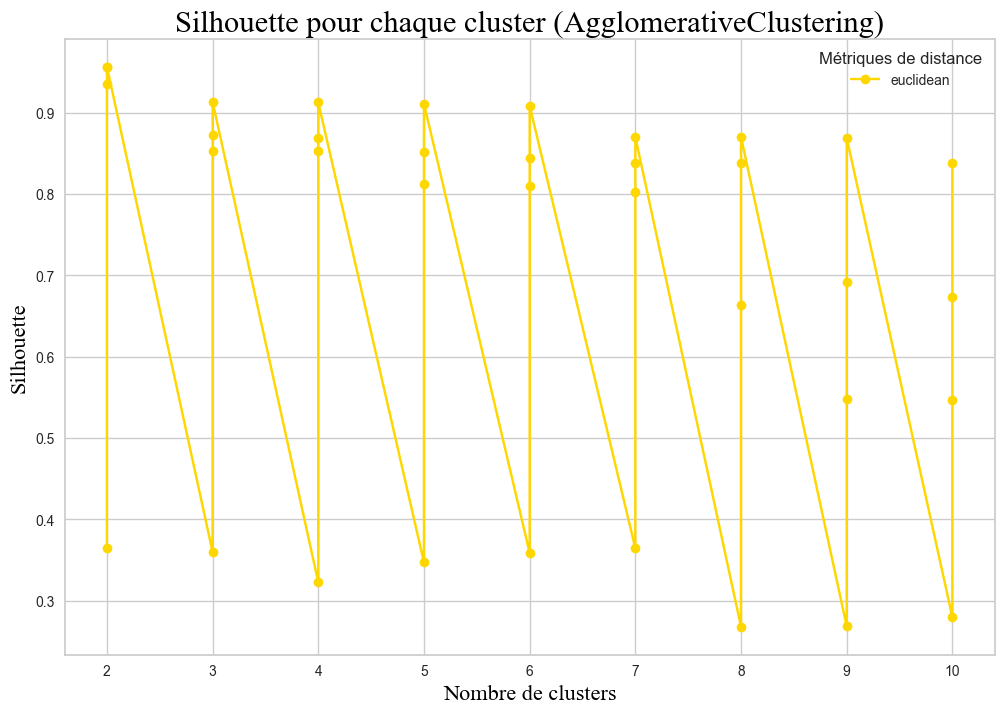

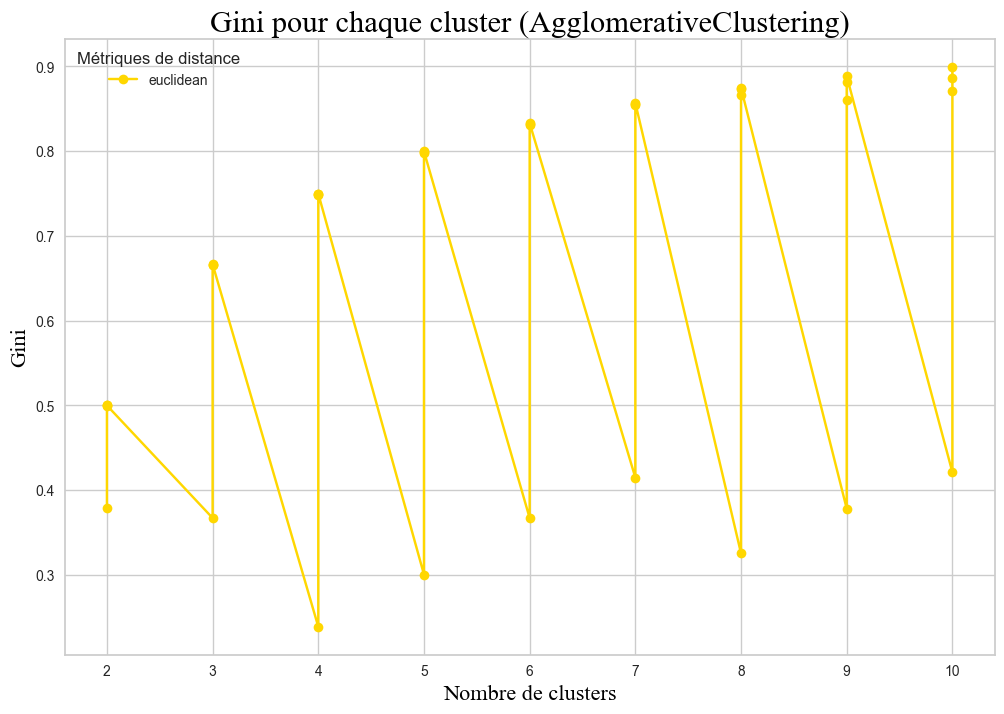

'Meilleur score de silhouette : '

,Hyperparametre,distance_metric,Coefficient silhouette,Indice Gini,Temps calcul,Nombre Clusters
2,"{'n_clusters': 2, 'linkage': 'average'}",euclidean,0.95656,0.49995,9.28591,2


In [42]:
# Afficher X pour être sûr des données d'entrainement
display("Voici les données dans X :", X.head(3))
display(X.shape)

# Prendre seulement 20% des données
X_small, _ = train_test_split(X, test_size=0.8, random_state=42)

# Standardiser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_small)

# Instancier l'estimateur et la classe ClusteringEstimator
cah = AgglomerativeClustering()
estimator_cah = ClusteringEstimator(cah)

# Gammes d'hyperparamètres (nombre de clusters)
n_clusters_range = range(k_range[0], k_range[1] + 1)
linkage_options = ['ward', 'complete', 'average', 'single']

# Gamme de distance_metric
distance_metric_range = ['euclidean']
# distance_metric_range = ['euclidean', 'manhattan', 'cosine', 'l1', 'l2', 'cityblock']

# POUR chaque distance_metric, chaque nombre de clusters et chaque option de linkage
for distance_metric in distance_metric_range:
    for n_clusters in n_clusters_range:
        for linkage_option in linkage_options:
        
            # Définir les hyperparamètres et entrainer l'estimateur
            estimator_cah.set_hyperparameters({'n_clusters': n_clusters, 'linkage': linkage_option})
            estimator_cah.fit(X_scaled, distance_metric=distance_metric)

# Afficher les graphiques
estimator_cah.plot(plot_type='silhouette')

# Afficher les graphiques
estimator_cah.plot(plot_type='gini')

# Afficher la ligne avec le meilleur score de silhouette
best_silhouette_score = estimator_cah.performance_metrics.loc[estimator_cah.performance_metrics['Coefficient silhouette'].idxmax()]

display("Meilleur score de silhouette : ", best_silhouette_score.to_frame().T)

Nous affichons les résultats du gridsearchCV pour inspection.

In [43]:
# Afficher les résultats silhouette en les classant dans l'ordre decroissant 
display(estimator_cah.performance_metrics.sort_values(by='Coefficient silhouette', ascending=False).head(10))

# #to csv
# estimator_cah.performance_metrics.to_csv('./data/estimator_cah.csv', sep='\t', encoding='utf-8')

,Hyperparametre,distance_metric,Coefficient silhouette,Indice Gini,Temps calcul,Nombre Clusters
2,"{'n_clusters': 2, 'linkage': 'average'}",euclidean,0.95656,0.49995,9.28591,2
3,"{'n_clusters': 2, 'linkage': 'single'}",euclidean,0.95656,0.49995,1.58113,2
1,"{'n_clusters': 2, 'linkage': 'complete'}",euclidean,0.93507,0.49984,9.17610,2
7,"{'n_clusters': 3, 'linkage': 'single'}",euclidean,0.91343,0.66651,1.52852,3
11,"{'n_clusters': 4, 'linkage': 'single'}",euclidean,0.91263,0.74968,1.51920,4
15,"{'n_clusters': 5, 'linkage': 'single'}",euclidean,0.91104,0.79968,1.62584,5
19,"{'n_clusters': 6, 'linkage': 'single'}",euclidean,0.90849,0.83302,1.52770,6
6,"{'n_clusters': 3, 'linkage': 'average'}",euclidean,0.87257,0.66598,9.10641,3
23,"{'n_clusters': 7, 'linkage': 'single'}",euclidean,0.87030,0.85677,1.62536,7
27,"{'n_clusters': 8, 'linkage': 'single'}",euclidean,0.87023,0.87463,1.63519,8


Le meilleur score de silhouette est obtenu avec 2 clusters, mais cette segmentation n'est pas assez fine pour notre client.

Nous réalisons une segmentation avec 6 clusters pour pouvoir comparer les résultats avec la segmentation KMeans.

## <span style='background:yellow; color:black'>2/ Analyse de la qualité du clustering</span>

Nous réalisons la segmentation de 6 clusters avec un CAH avec linkage 'single' (meilleurs performances pour 6 clusters).

In [44]:
# Créer la matrice de lien (cluster1, cluster2, distance, nbr d'observations)
linkage_array = linkage(X_scaled, method='average')

# Former 5 clusters à partir de la matrice de lien (maxclust=5)
clusters = fcluster(linkage_array, 6, criterion='maxclust')

# Dataframe avec la feature des clusters
df_rfms_cluster_cah = pd.concat([X_small, pd.Series(clusters, index=X_small.index, name='Cluster')], axis=1)

# Affichage
display(df_rfms_cluster_cah.head(3))

,recence,frequence,montant,satisfaction,Cluster
customer_unique_id,,,,,
c8c66a09a6402e1799afa3064a0ade6e,153,1,318.97,1.0,3
7b8637d830cbfdecb836c1ea12548d30,386,1,32.75,5.0,3
78ee26fa1c9d46b1473fb7343a000ee8,440,1,206.99,4.0,3


### <span style='background:green; color:white'>a/ Répartition des clusters</span>

In [45]:
# Compter le nombre de lignes par cluster et trier les index
cluster_counts = df_rfms_cluster_cah['Cluster'].value_counts().sort_index()

# Afficher les comptes
display(cluster_counts)

Cluster
1        9
2        3
3    18921
4        2
5        8
6        1
Name: count, dtype: int64

Le cluster 1 regroupe la grande majorité des clients (>99%)

### <span style='background:green; color:white'>b/ Indice de Davies-Bouldin</span>

La qualité du clustering peut être évalué avec l'indice de Davies-Bouldin. Cet indice indique la "similarité" moyenne entre les clusters, la "similarité" étant une mesure qui compare la distance entre les clusters à la taille des clusters eux-mêmes.

Plus le score est faible, plus les clusters sont denses et séparés. Par exemple, lorsqu'il est :
- <1 : le clustering est considéré comme bon. 
- <2 : le clustering est considéré comme moyen. 
- \>3 : le clustering est considéré comme mauvais. 

In [46]:
# Score de Davies-Bouldin
db_score = davies_bouldin_score(X_scaled, clusters)
print(f"Le score de Davies-Bouldin est : {round(db_score, 2)}")

Le score de Davies-Bouldin est : 0.48


Le score de Davies-Bouldin évoque un bon clustering. 

### <span style='background:green; color:white'>c/ Plot 3D des clusters</span>

Nous affichons un plot 3D des clusters.

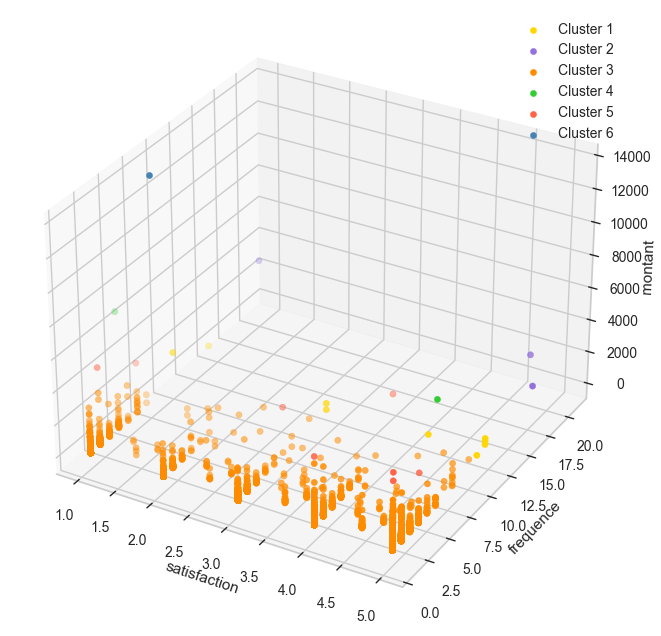

In [47]:
# df de travail
df = df_rfms_cluster_cah

# Créer une figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Créer une liste de labels pour les clusters
cluster_labels = sorted(df['Cluster'].unique())

# Tracer les points pour chaque cluster
for cluster in cluster_labels:
    mask = df['Cluster'] == cluster
    ax.scatter(df[mask]['satisfaction'], df[mask]['frequence'], df[mask]['montant'], c=colors_list[cluster - 1], label=f'Cluster {cluster}')

# Titre des axes
ax.set_xlabel('satisfaction')
ax.set_ylabel('frequence')
ax.set_zlabel('montant')

# Ajouter une légende
ax.legend()
plt.show()

### <span style='background:green; color:white'>d/ Distribution et moyenne par cluster</span>

Nous affichons les boxplots des clusters pour chaque feature afin de vérifier la pertinence du clustering.

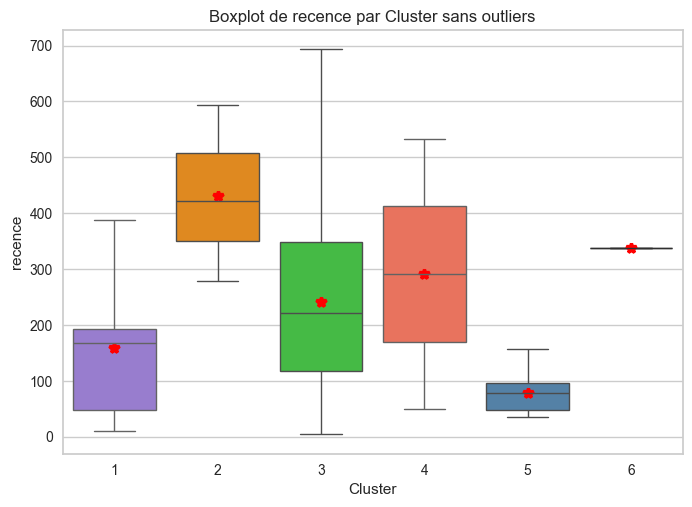

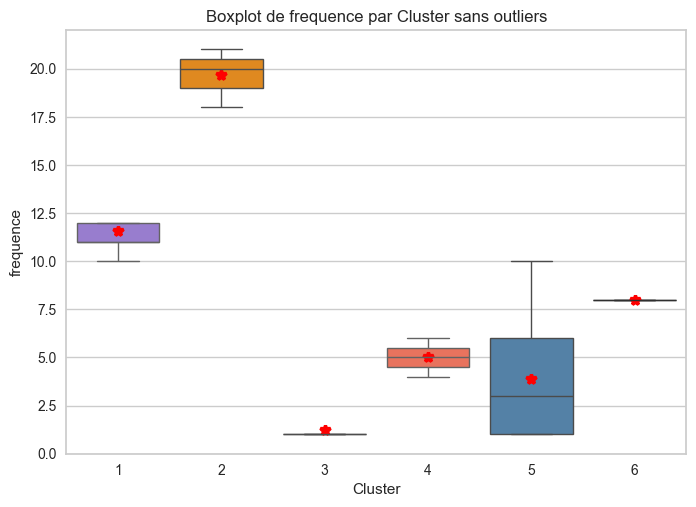

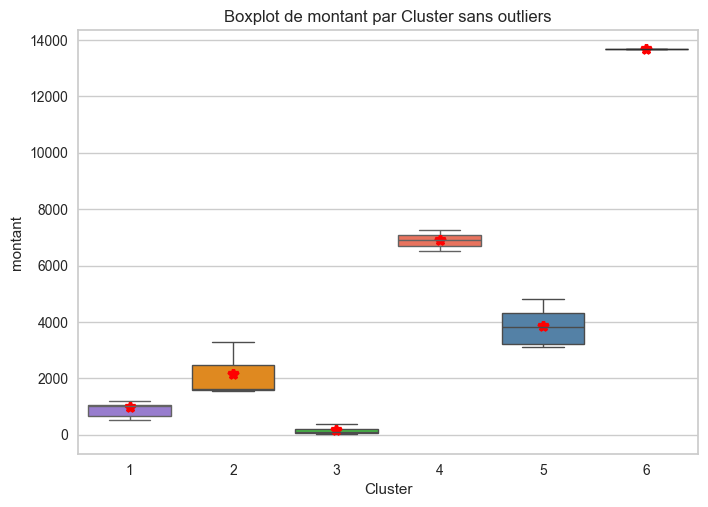

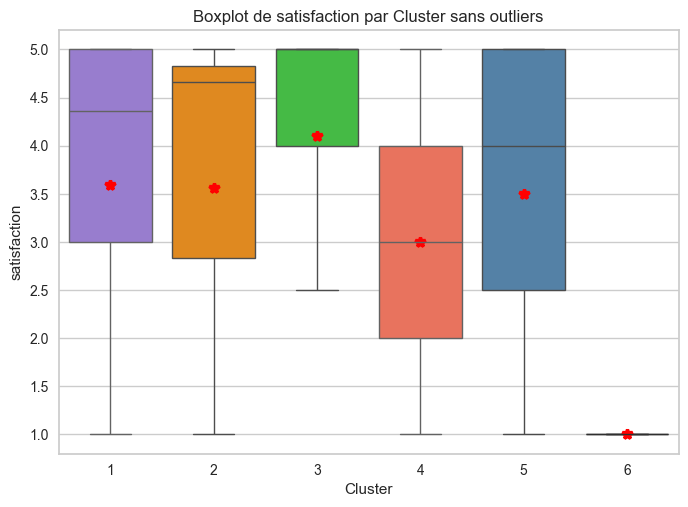

In [48]:
# Afficher les boxplots
afficher_boxplot(df, cluster_col_nom='Cluster', outliers=False)

Nous affichons la moyenne des clusters pour chaque feature afin de vérifier la pertinence du clustering.

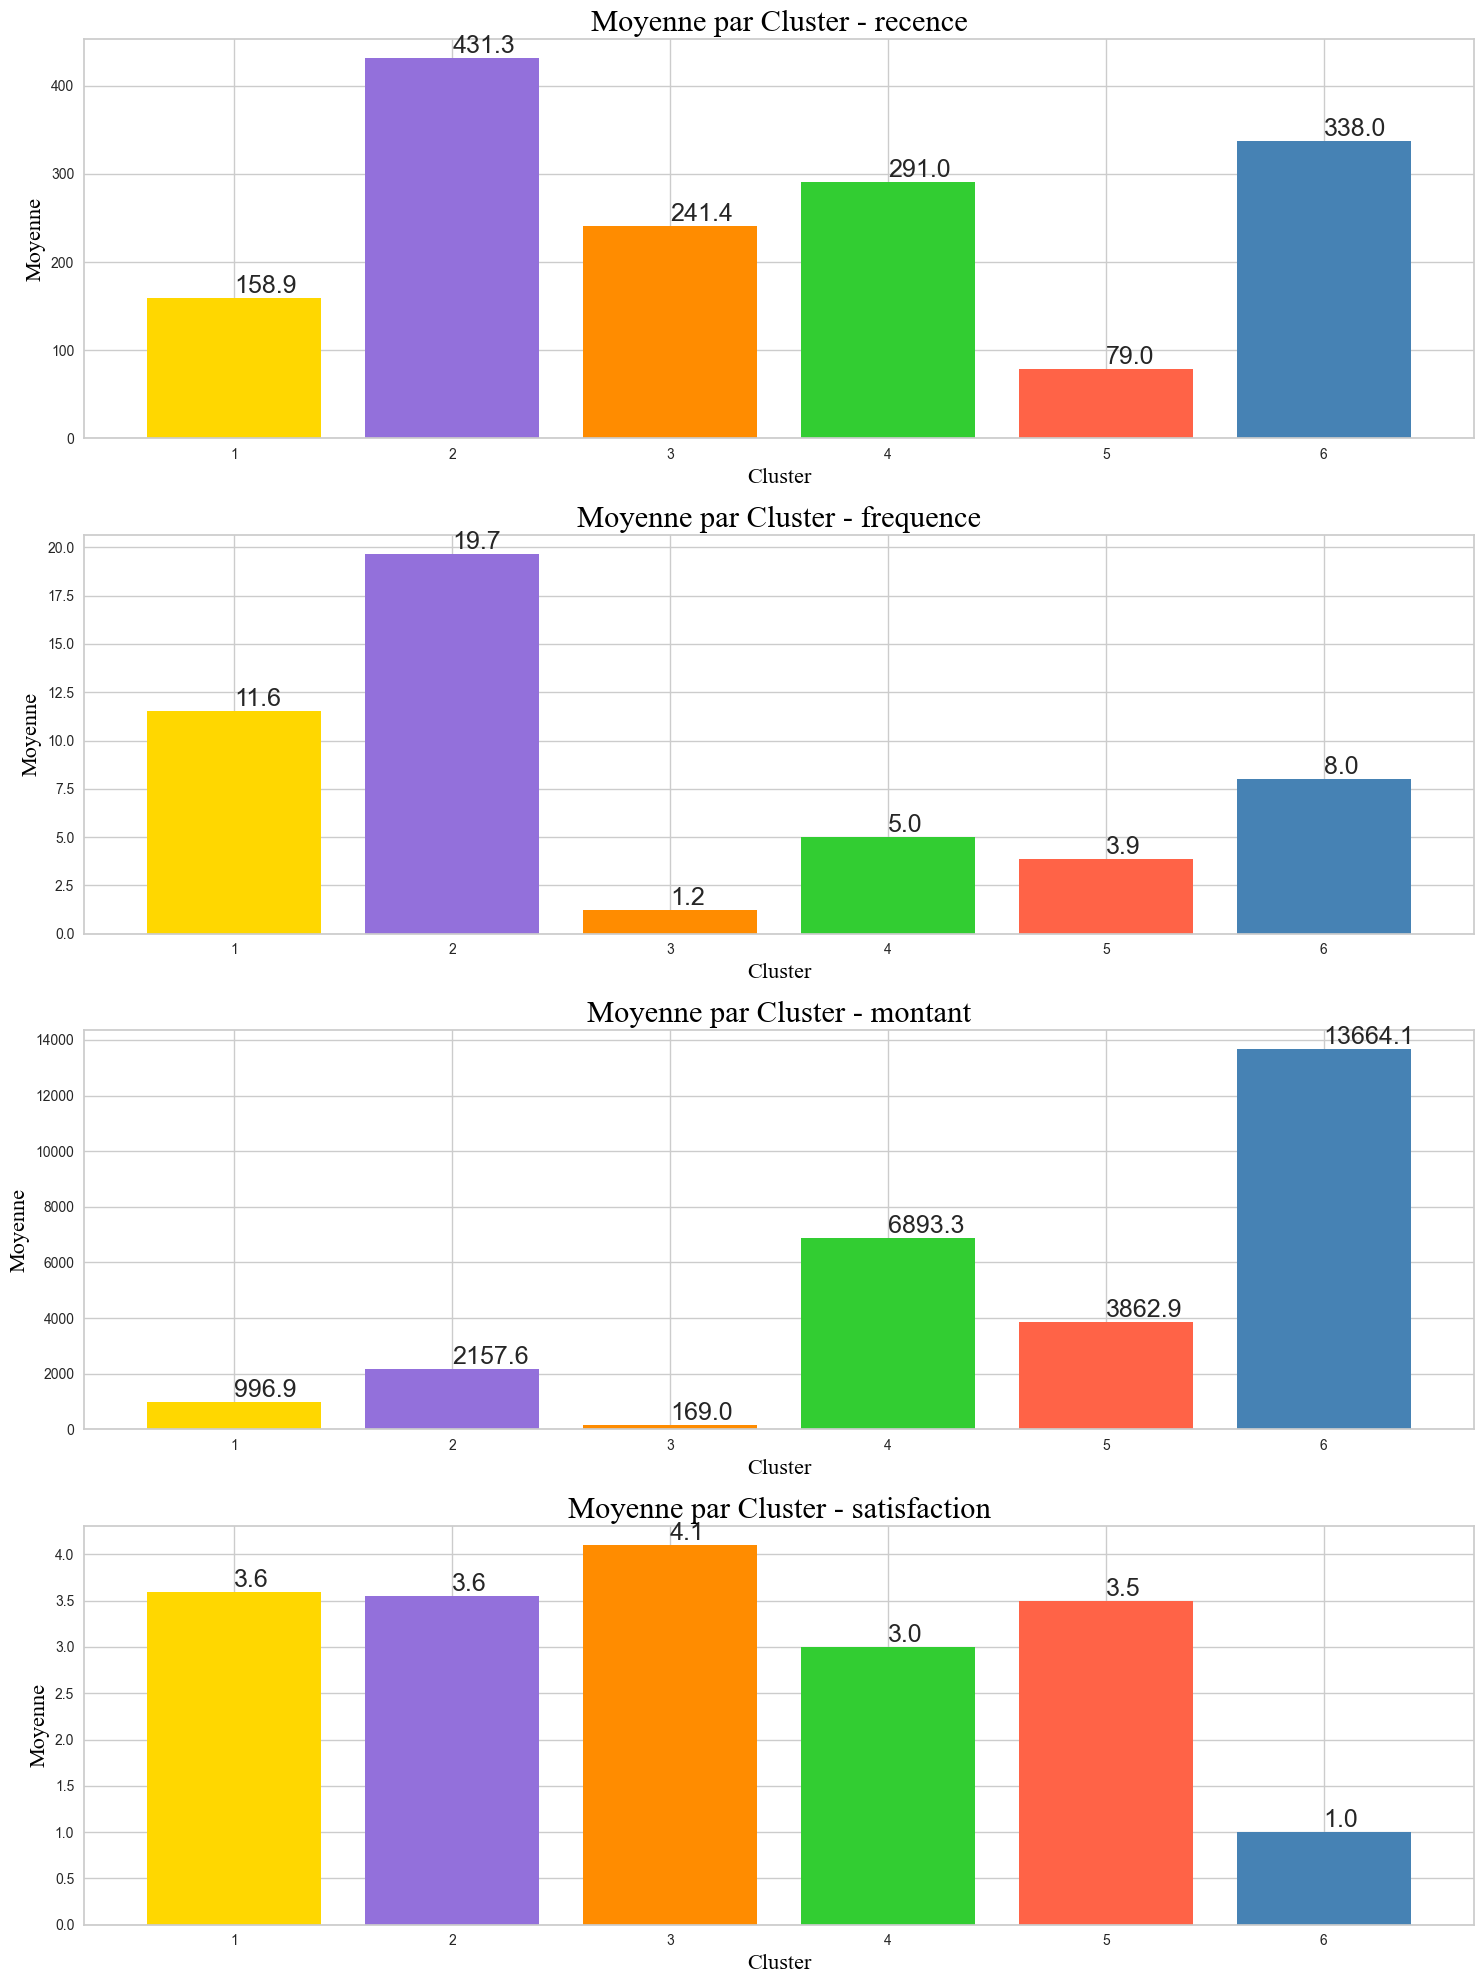

In [49]:
# Tracer la moyenne par cluster pour chaque feature
moyenne_par_cluster_cah = tracer_moyenne_par_cluster(df)

Les écarts entre les clusters sont un peu plus marqués que pour les k-means.

### <span style='background:green; color:white'>e/ Radar par cluster</span>

Nous normalisons les moyennes des features pour pouvoir les comparer entre les clusters. 

In [50]:
# Créer un scaler
scaler = MinMaxScaler()

# Ajuster et transformer les données
moyenne_par_cluster_scaled = scaler.fit_transform(moyenne_par_cluster_cah)

# Convertir le résultat en DataFrame
moyenne_par_cluster_scaled = pd.DataFrame(moyenne_par_cluster_scaled, columns=moyenne_par_cluster.columns)

# Affichage
display(moyenne_par_cluster_scaled)

,recence,frequence,montant,satisfaction
0,0.22674,0.56052,0.06135,0.83650
1,1.00000,1.00000,0.14736,0.82348
2,0.46087,0.00000,0.00000,1.00000
3,0.60170,0.20532,0.49828,0.64446
4,0.00000,0.14436,0.27373,0.80558
5,0.73510,0.36787,1.00000,0.00000


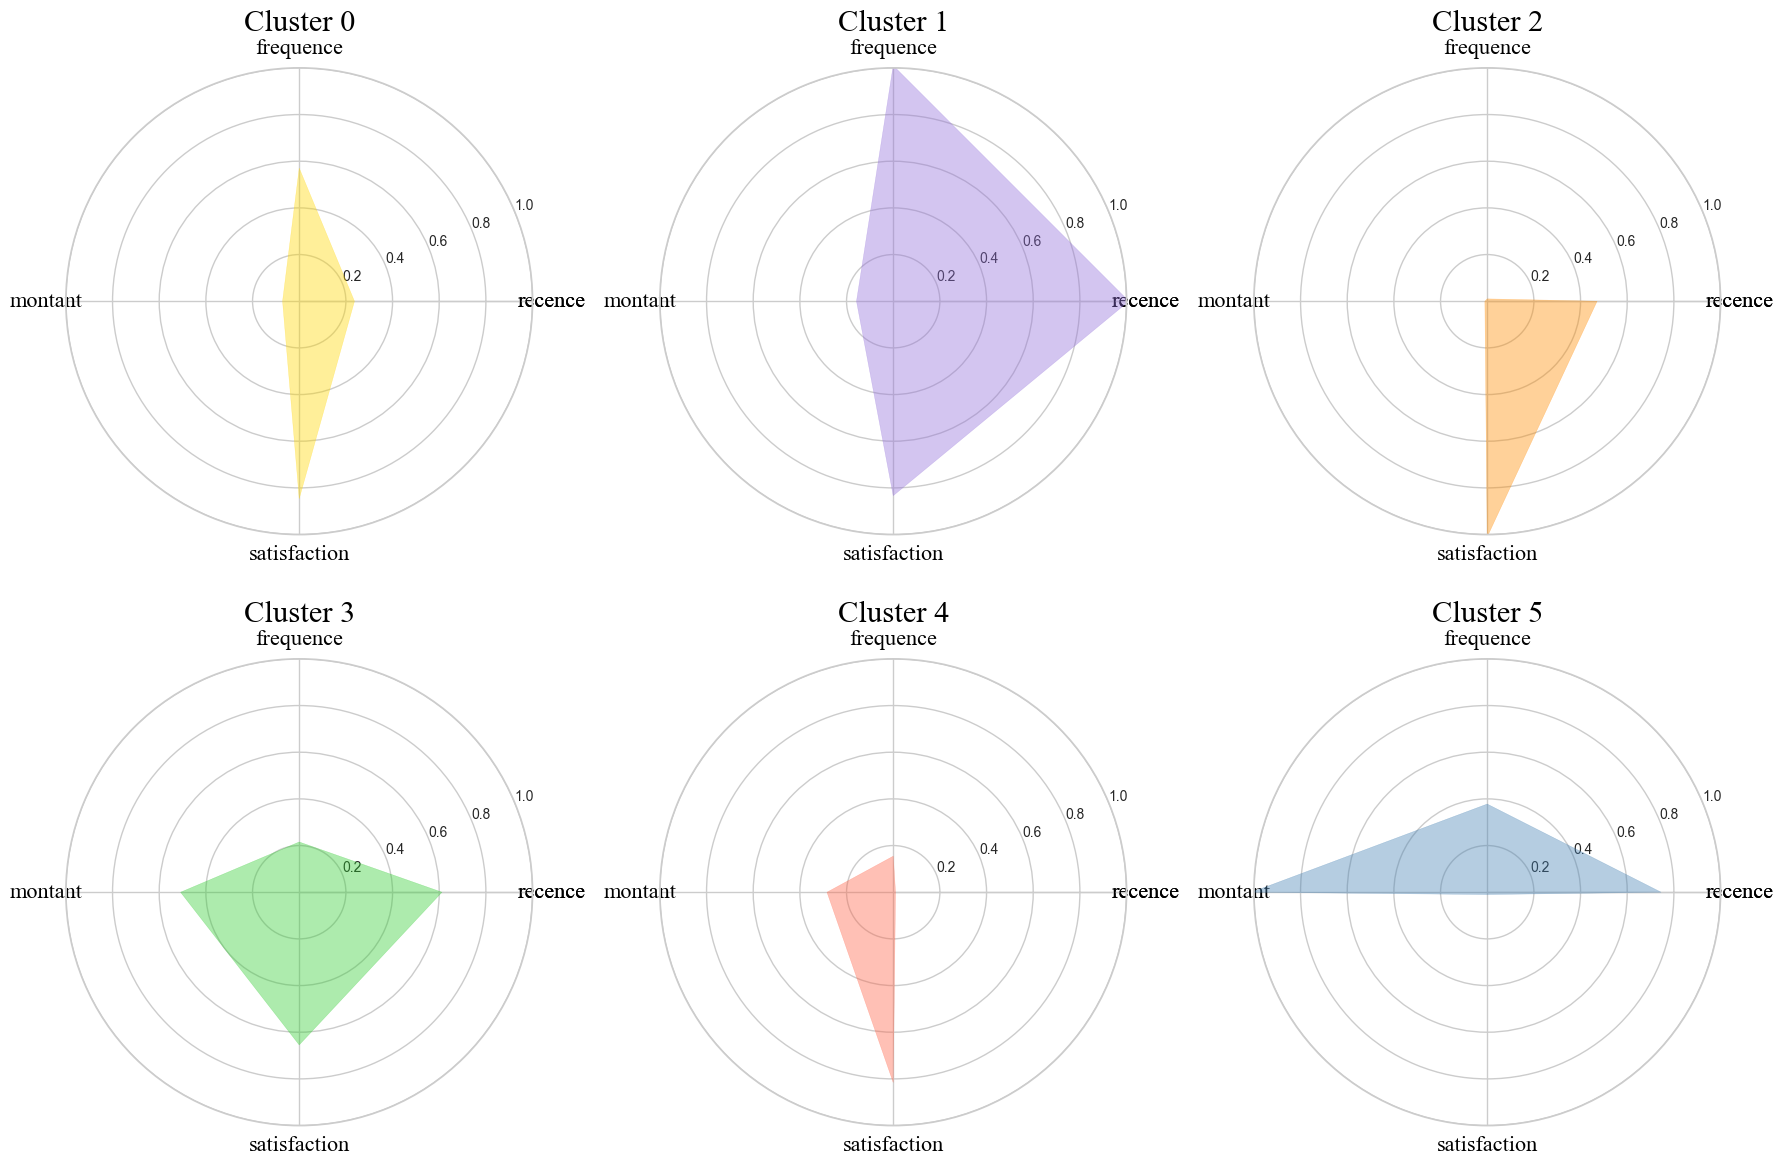

In [51]:
# Tracer un graphique radar pour chaque cluster
tracer_radar_par_cluster(moyenne_par_cluster_scaled, alpha=0.40)

<div class="alert alert-block alert-info"><b>Bilan: </b> <br>
Le clustering CAH de la RFMS n'est pas possible sur la totalité des clients pour cause de mémoire insuffisante. De plus, la segmentation n'est ni assez fine, ni de bonne qualité pour notre client. <br>

# <span style='background:blue'>Etape 4 : DBScan RFM + Satisfaction</span>

Nous réalisons le même travail de segmentation que précédemment mais avec une approche de Clustering DBSCAN.

Nous selectionnons donc la RFM + Satisfaction pour réaliser la segmentation des clients.

In [52]:
# Afficher aperçu et dimension du df
display(rfms.head(3))
display(rfms.shape)

# Données de travail
X = rfms

,recence,frequence,montant,satisfaction
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19,4.0
0000f46a3911fa3c0805444483337064,541,1,86.22,3.0


(94720, 4)

## <span style='background:yellow; color:black'>1/ Détermination du nombre de cluster</span>

### <span style='background:green; color:white'>Score Silhouette</span>

Nous ne pouvons pas réaliser la recherche du nombre de cluster optimal avec la silhouette car la mémoire de notre ordinateur est insuffisante pour réaliser les calculs avec la totalité du dataset. 

Nous le réalisons sur un échantillon de 20% des clients du dataset.

'Voici les données dans X :'

,recence,frequence,montant,satisfaction
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19,4.0
0000f46a3911fa3c0805444483337064,541,1,86.22,3.0


(94720, 4)

C:\Users\pierr\AppData\Local\Temp\ipykernel_14020\3521338644.py:110: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.performance_metrics = pd.concat([self.performance_metrics, new_row], ignore_index=True)
C:\Users\pierr\AppData\Local\Temp\ipykernel_14020\3521338644.py:110: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.performance_metrics = pd.concat([self.performance_metrics, new_row], ignore_index=True)
C:\Users\pierr\AppData\Local\Temp\ipykernel_14020\3521338644.py:110: FutureWarning: 

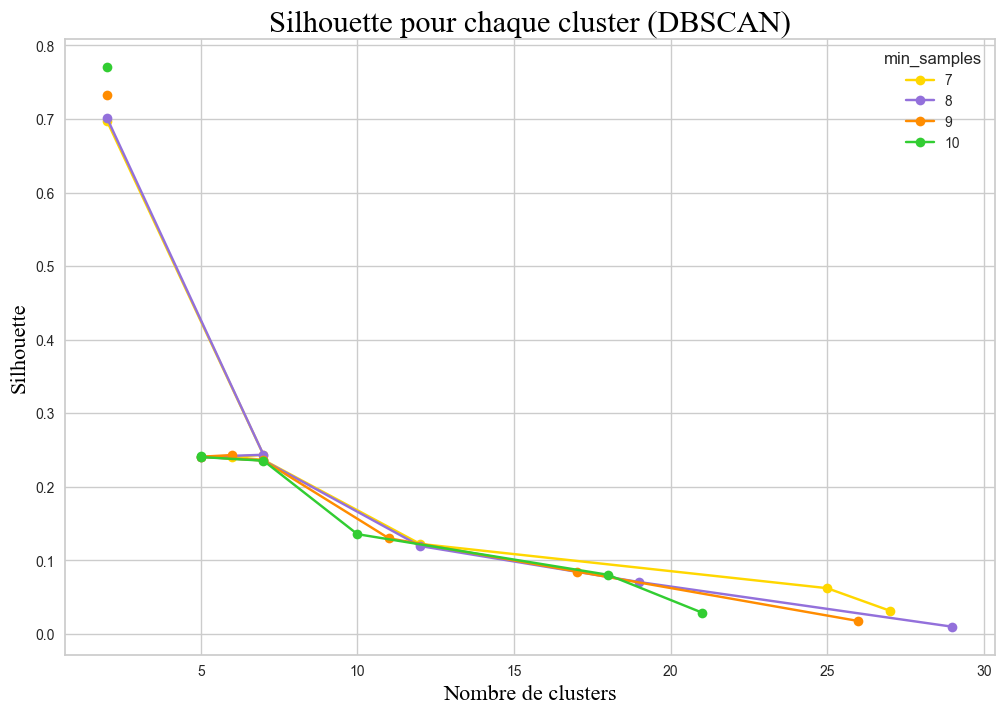

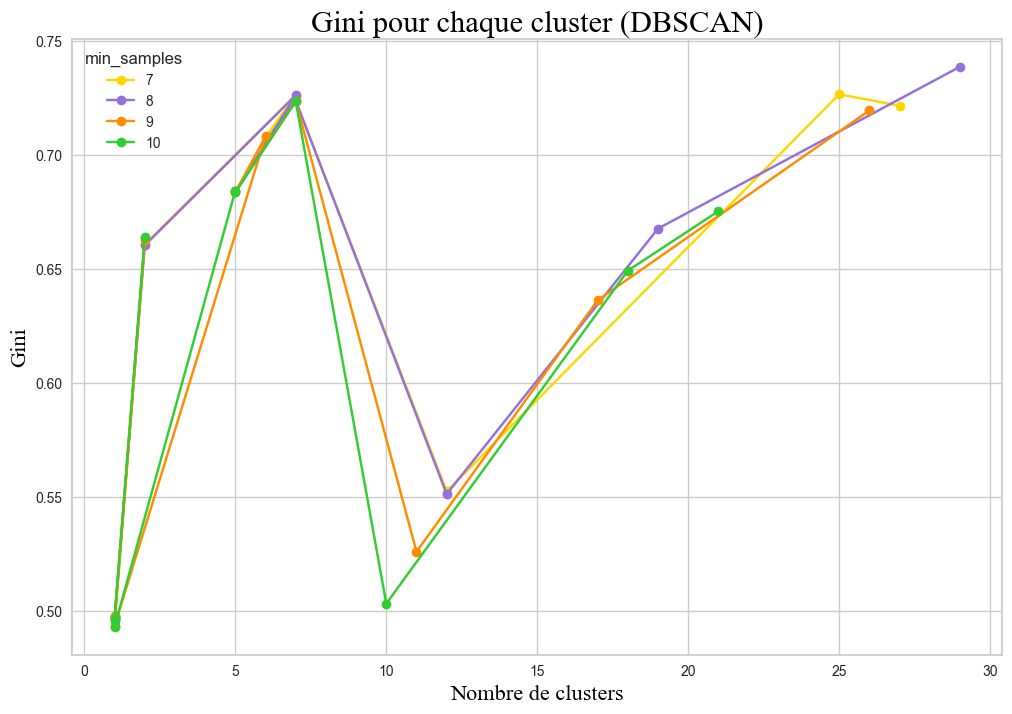

'Meilleur score de silhouette : '

,Hyperparametre,distance_metric,Coefficient silhouette,Indice Gini,Temps calcul,Nombre Clusters
39,"{'eps': 2.0, 'min_samples': 10}",euclidean,0.77099,0.66382,4.82044,2


In [53]:
# Afficher X pour être sûr des données d'entrainement
display("Voici les données dans X :", X.head(3))
display(X.shape)

# Prendre seulement 20% des données
X_small, _ = train_test_split(X, test_size=0.8, random_state=42)

# Standardiser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_small)

# Instancier l'estimateur et la classe ClusteringEstimator
dbscan = DBSCAN()
estimator_dbscan = ClusteringEstimator(dbscan)

# Définir les gammes d'hyperparamètres
eps_range = np.linspace(0.2, 2, 10)
min_samples_range = list(range(7, 11))

# Gamme de distance_metric
distance_metric_range = ['euclidean']
# distance_metric_range = ['euclidean', 'manhattan', 'cosine', 'l1', 'l2', 'cityblock']

# POUR chaque eps et chaque min_samples
for eps in eps_range:
    for min_samples in min_samples_range:

        # # Définir les hyperparamètres et entrainer l'estimateur
        estimator_dbscan.set_hyperparameters({'eps': eps, 'min_samples': min_samples})
        estimator_dbscan.fit(X_scaled, distance_metric='euclidean')

# Afficher les graphiques
estimator_dbscan.plot_dbscan(plot_type='silhouette', min_samples_range=min_samples_range)

# Afficher les graphiques
estimator_dbscan.plot_dbscan(plot_type='gini', min_samples_range=min_samples_range)

# Afficher la ligne avec le meilleur score de silhouette
best_silhouette_score = estimator_dbscan.performance_metrics.loc[estimator_dbscan.performance_metrics['Coefficient silhouette'].idxmax()]

display("Meilleur score de silhouette : ", best_silhouette_score.to_frame().T)

Nous affichons les résultats du gridsearchCV pour inspection.

In [54]:
# Afficher les résultats silhouette en les classant dans l'ordre decroissant 
display(estimator_dbscan.performance_metrics.sort_values(by='Coefficient silhouette', ascending=False).head(10))

# #to csv
# estimator_dbscan.performance_metrics.to_csv('./data/estimator_dbscan.csv', sep='\t', encoding='utf-8')

,Hyperparametre,distance_metric,Coefficient silhouette,Indice Gini,Temps calcul,Nombre Clusters
39,"{'eps': 2.0, 'min_samples': 10}",euclidean,0.77099,0.66382,4.82044,2
30,"{'eps': 1.6, 'min_samples': 9}",euclidean,0.73309,0.66244,4.11503,2
25,"{'eps': 1.4000000000000001, 'min_samples': 8}",euclidean,0.70149,0.66023,3.15244,2
24,"{'eps': 1.4000000000000001, 'min_samples': 7}",euclidean,0.69734,0.66065,3.22859,2
21,"{'eps': 1.2, 'min_samples': 8}",euclidean,0.24355,0.72603,2.67756,7
20,"{'eps': 1.2, 'min_samples': 7}",euclidean,0.24347,0.72614,2.83717,7
22,"{'eps': 1.2, 'min_samples': 9}",euclidean,0.24316,0.70802,2.73711,6
23,"{'eps': 1.2, 'min_samples': 10}",euclidean,0.24226,0.68421,2.73373,5
18,"{'eps': 1.0, 'min_samples': 9}",euclidean,0.24093,0.68352,2.44539,5
16,"{'eps': 1.0, 'min_samples': 7}",euclidean,0.24077,0.70776,2.46704,6


Le meilleur score de silhouette est obtenu avec 2 clusters, mais cette segmentation n'est pas assez fine pour notre client.

Nous réalisons une segmentation avec 6 clusters pour pouvoir comparer les résultats avec la segmentation KMeans.

## <span style='background:yellow; color:black'>2/ Analyse de la qualité du clustering</span>

Nous réalisons la segmentation de 6 clusters avec un DBSCAN avec eps = 1,2 et min_samples = 9 (meilleurs performances pour 6 clusters).

In [55]:
# Instancier l'estimateur
model_dbscan_4f = DBSCAN(eps=1.2, min_samples=9)

# Fit le modèle sur les données
model_dbscan_4f.fit(X_scaled)

# Dataframe avec la feature des clusters
df_rfms_cluster_dbscan = pd.concat([X_small, pd.Series(model_dbscan_4f.labels_, index=X_small.index, name='Cluster')], axis=1)

# Affichage
display(df_rfms_cluster_dbscan.head(3))

,recence,frequence,montant,satisfaction,Cluster
customer_unique_id,,,,,
c8c66a09a6402e1799afa3064a0ade6e,153,1,318.97,1.0,0
7b8637d830cbfdecb836c1ea12548d30,386,1,32.75,5.0,0
78ee26fa1c9d46b1473fb7343a000ee8,440,1,206.99,4.0,0


### <span style='background:green; color:white'>a/ Répartition des clusters</span>

In [56]:
# Compter le nombre de lignes par cluster et trier les index
cluster_counts = df_rfms_cluster_dbscan['Cluster'].value_counts().sort_index()

# Afficher les comptes
print(cluster_counts)

Cluster
-1      171
 0    16119
 1     2101
 2      355
 3      151
 4       38
 5        9
Name: count, dtype: int64


Il y a un cluster qui regroupe un grande majorité des clients.

### <span style='background:green; color:white'>b/ Indice de Davies-Bouldin</span>

La qualité du clustering peut être évalué avec l'indice de Davies-Bouldin. Cet indice indique la "similarité" moyenne entre les clusters, la "similarité" étant une mesure qui compare la distance entre les clusters à la taille des clusters eux-mêmes.

Plus le score est faible, plus les clusters sont denses et séparés. Par exemple, lorsqu'il est :
- <1 : le clustering est considéré comme bon. 
- <2 : le clustering est considéré comme moyen. 
- \>3 : le clustering est considéré comme mauvais. 

In [57]:
# Score de Davies-Bouldin
db_score = davies_bouldin_score(X_scaled, model_dbscan_4f.labels_)
print(f"Le score de Davies-Bouldin est : {round(db_score, 2)}")

Le score de Davies-Bouldin est : 1.9


Le score de Davies-Bouldin évoque un clustering moyen. 

<div class="alert alert-block alert-info"><b>Bilan: </b> <br>
Inutile de poursuivre l'analyse avec DBSCAN. Tout d'abord, nous n'avons pas la puissance computationnelle pour réaliser le clustering sur la totalité des clients. Ensuite, les résultats ne sont pas satisfaisants.

</div> 

# <span style='background:blue'>Etape 4 : Exportation du dataset nettoyé</span>
___

Nous exportons le dataset avec les clusters issus de la segmentation KMeans.

In [58]:
# Affichage
display(df_rfms_cluster.head(3))
display(df_rfms_cluster.shape)

,recence,frequence,montant,satisfaction,Cluster
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90,5.0,0
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19,4.0,0
0000f46a3911fa3c0805444483337064,541,1,86.22,3.0,3


(94720, 5)

Nous allons sauvegarder le dataset pour l'utiliser la simulation de la maintenance

In [59]:
# Chemin du dossier et nom du fichier de l'export nettoyé
output_directory = "data/cleaned"
nomFichier_export = "olist_clients_segmentation_kmeans_rfms.csv"

# Vérification de l'existence du dossier
os.makedirs(output_directory, exist_ok=True)

# Chemin complet du fichier export
output_file = os.path.join(output_directory, nomFichier_export)

# export df nettoyé en CSV (tabulation en séparateur)
df_rfms_cluster.to_csv(output_file, sep='\t', encoding='utf-8', index=True)

# <span style='background:blue'>Conclusion</span>

La modélisation de la segmentation des clients avec la méthode KMeans avec le dataset de la RFM + Satisfaction permet de segmenter les clients en 6 groupes. Le score de silhouette de 0,37 et l'indice de Davies-Bouldin de 0,97 évoquent un clustering satisfaisant.

Cette segmentation permet de distinguer les bons et les mauvais clients en termes de :

- Commande
  - Bon clients  : 
    - Cluster 2 (<2%) qui font peu d'achat mais avec des montants importants. 
    - Cluster 4 (<1%) qui font beaucoup d'achat mais avec des montants faibles.
  
  - Mauvais clients :
    - Cluster 3 (31%) qui n'ont pas fait d'achat la dernière année et en plus qui font un achat unique de faible montant.

- Satisfaction
  - Bon clients :
    - Cluster 0 (41%) et cluster 3 (31%) qui sont très satisfaits.
    - Cluster 5 (9%) qui sont satisfaits.
  - Mauvais clients
    - Cluster 1 (16%) qui sont pas du tout satisfaits.

Voici des noms de clusters pour faciliter la compréhension :
- Cluster 0 :  Nouveaux satisfaits<br>
- Cluster 1 :  Grincheux<br>
- Cluster 2 :  Prodigues <br>
- Cluster 3 :  Anciens satisfaits<br>
- Cluster 4 :  Loyaux malgré tout<br>
- Cluster 5 :  Loyalistes potentiels<br>

In [60]:
# Calculer et afficher la durée totale
total_time = time.time() - start_time

# Convertir en minutes et secondes
minutes, seconds = divmod(total_time, 60)

# Afficher la durée totale
print("Durée totale pour faire tourner le notebook : {0} minute(s) {1} seconde(s)".format(int(minutes), int(seconds)))

Durée totale pour faire tourner le notebook : 54 minute(s) 12 seconde(s)
